# Forecasting economic activity using a text-classification model
In this notebook all the necessary commands to run the sentiment analysis model to forecast economic activity using newspaper headlines will be executed.
The structure of this notebook is as follows:

1. Webscraping Newspaper Headlines from the Web
2. Importing and Preparing Indicator for Economic Activity
3. Labeling Headlines with Sentiment Analysis Model
4. Forecasting Economic Activity using Sentiment Labels of Headlines

### Webscraping Newspaper Headlines from the Web
At first, I will import the relevant libriaries needed to execute the web-scraping part. All of the libriaries needed for the other parts of the project will be imported in their specific chapter. Every imported library has a short description of what I'm using the library for. 

In [12]:
from time import sleep  # Gives the option to stop the execution for a specified time
from time import time # Gives the option to time a specific process
from selenium import webdriver  # WebDriver
from selenium.webdriver.common.by import By  # For Crawling
from selenium.webdriver.common.keys import Keys  # For Crawling
from selenium.webdriver.chrome.options import (
    Options,
)  # For setting further options for the driver
from selenium.common.exceptions import NoSuchElementException  # Avoiding Elements that are not there
from selenium.webdriver.support import expected_conditions as EC  # Conditions
from selenium.webdriver.support.ui import (
    WebDriverWait,
)  # Make sure the element is loaded
from pathlib import Path #importing the path of the repository
import pandas as pd # use dataframes
import numpy as np # use arrays and perform mathematical operations on them
import datetime # change strings into format 'datetime'
import ast # convert string representations of data structures back into their original form

First I will resolve the root of the repistory and save it as a variable since I will use it a lot in this notebook.

In [13]:
ROOT = Path().parent.resolve() #Resolving folder directory of GitHub repistory
ROOT # This should be the path in which the clone of the GitHub repistory is located in

WindowsPath('C:/Users/INSPIRON 15-3567/Desktop/Uni/Uni Bonn/OSE Deep Learning/myfinalproject/final-project-s55fschm')

Next, I will start the chromedriver to start with the webcrawling and scraping.

In [3]:
# Path configurations:
DRIVER_PATH = ROOT/"chromedriver.exe"

# Set some options: default
options = Options()

# Start driver:
driver = webdriver.Chrome(DRIVER_PATH, options=options)

C:\Users\INSPIRON 15-3567\AppData\Local\Temp\ipykernel_5384\1175390648.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(DRIVER_PATH, options=options)


Now, I will crawl to the newspaper website where I will scrape the headlines from and go to their "Schlagzeilen" (=headlines in german) section to start scraping the headlines. First,however, I will accept the cookie pop-up, so that it does not bother me in the further part of the scraping process.

In [4]:
web_site = "https://www.welt.de/schlagzeilen/" # newspaper website, section: headlines
driver.get(web_site) # go to that website
sleep(3) # wait for 3 seconds to check if everything works
# With the following lines, I ensure that Cookies are accepted on the website, so that the pop-up message does not block the
# main content of the website
try: 
    driver.switch_to.frame(driver.find_element(By.XPATH, "//iframe[@title='SP Consent Message']"))
    driver.find_element(By.XPATH, "//button[@title='Alle akzeptieren']").click()
except NoSuchElementException:
    print("Cookies already accepted!")
driver.switch_to.default_content() # Switching back to main content in case the driver hasn't done by itself

At next, I will define three functions to do the webscraping part of this section. The first function will convert the strings from the sub headline of the headline into lowercase words and then capitalize the first word. This is because otherwise the entire sub headline is uppercase which could mess with the labeling of the model since I am using a cased-model.

In [5]:
def convert_to_normal_style(strings):
    result = []
    for string in strings:
        words = string.lower().split()  # Convert to lowercase and split into words
        words[0] = words[0].capitalize()  # Capitalize the first word
        result.append(" ".join(words))  # Join words back together and append to result
    return result

This function collects the headlines from the website. Since the format of the headline category and sub headline sometimes change slightly due to other tags being attached to the headline (e.g. "Meinung"=opinion or "Weltplus" the premium feature) I have to try out several options to make sure that I am collecting the right elements that I am looking for.

In [6]:
def collect_headlines_Welt():
    #Extracting headline date:
    headline_date = driver.find_element(By.XPATH, "//h2[@class='c-tabs__headline']").text
    Weekdays=["MONTAG","DIENSTAG","MITTWOCH","DONNERSTAG","FREITAG","SAMSTAG","SONNTAG"]
    for days in Weekdays:
        headline_date = headline_date.replace(f"ALLE TEXTE VON {days}, DEM ", '')
    
    #getting the number of articles on the webpage to make sure that I do not webscrape too many headlines
    articles = driver.find_elements(By.XPATH, "/html/body/div[2]/div[2]/main/div[2]/div/div[3]/div[1]/div/article")
    number_of_articles= len(articles)
    
    # getting the headline category to not extract headlines from all categories
    headline_category=[]
    for i in range(1,number_of_articles+1):
        # Since some headlines do not have a category or tag (e.g. opinions) and additionally, tags are sometimes located
        # in different places we have to use the following lines to extract the right tag.
        try: 
            headline_category.append(driver.find_element(By.XPATH, f"//div[@class='c-tabs__panel-content']/article[{i}]/div/div[1]/div/span[1]/a").text)
        except NoSuchElementException:
            headline_category.append("No Tag")
        try:
            headline_category[-1]=driver.find_element(By.XPATH, f"//div[@class='c-tabs__panel-content']/article[{i}]/div/div[1]/div/span[2]/a").text
        except NoSuchElementException:
            headline_category[-1]= headline_category[-1]
    
    # creating a list filled with boolean values whether or not the headline belongs to one of the relevant categories
    headline_politics_economics = []
    for category in headline_category:
        headline_politics_economics.append(category == 'POLITIK' or category == 'WIRTSCHAFT' or category=='FINANZEN') # Filtering for headlines in the 
        # category "Economics" or "Politics" or "Finance"
    
    # Since every article on the website has a headline, but not every article on the website has a sub headline I have to use
    # different methods for both of them
    headline_elements = driver.find_elements(By.XPATH,"/html/body/div[2]/div[2]/main/div[2]/div/div[3]/div[1]/div/article/div/div[2]/h4/a")
    sub_headlines=[]
    headlines=[]
    for number_element in range(number_of_articles):
        if headline_politics_economics[number_element]== True: #only extracting headlines if they are in the right category
            try: 
                sub_headlines.append(driver.find_element(By.XPATH, f"/html/body/div[2]/div[2]/main/div[2]/div/div[3]/div[1]/div/article[{number_element}+1]/div/div[1]/div/span[@class='c-teaser__topic']").text)
            except NoSuchElementException:
                sub_headlines.append("No Subheadline")
            
            headlines.append(headline_elements[number_element].text)

    # Converting subheadlines into lower-case strings to avoid confusion by the sentiment analysis model
    sub_headlines = convert_to_normal_style(sub_headlines)
    # Joining headlines into one string
    full_headlines = [f"{sub_headline}: {headline}" if sub_headline != "No Subheadline" else headline for sub_headline, headline in zip(sub_headlines, headlines)]
    all_headlines = ", ".join(full_headlines) # joining all headlines from one day into one string

    return headline_date, all_headlines, full_headlines

The last function of the this first part of this notebook uses the previous two functions to scrape and correctly process the data. I also added a loading bar for convience.

In [7]:
def webscrape_headlines_welt(max_days):
    headline_dates=[]
    headlines=[]
    list_of_headlines=[]
    while len(headline_dates)< max_days:
        headline_date, headline, full_headlines=collect_headlines_Welt() #scraping headlines
        headline_dates.append(headline_date)
        # Processing two versions of the headlines: one as one combined string and one as a list:
        headlines.append(headline)
        list_of_headlines.append(full_headlines)
        
        # Loading bar:
        percent_done = int((len(headline_dates) / max_days) * 100)
        print(f"{percent_done}% ", end="", flush=True)
        
        # Switching to the next page/date as soon as all headlines are extracted:
        driver.find_element(By.CLASS_NAME, "c-pagination-link").click()
        driver.switch_to.default_content() # once again making sure that the right elements are loaded
        
    return headline_dates, headlines, list_of_headlines

In this next cell I coded up a small calculation help to find the right end date given a starting date if one wants to scrape a specific number of days like I do. In my case, I want to scrape 1000 days of headlines starting from the January 1st, 2008. 1000 is abitrairy in this case, however, the starting date is not since this is the earliest date where the indicator for economy activity, the truck toll mileage index, is available.

In [8]:
# Abitrairy starting date
start_date = datetime.date(2008, 1, 1)
target_days = 1000
target_date = start_date + datetime.timedelta(days=target_days-1) #Calculate target_date 1000 days starting date
target_date = target_date.strftime("%d-%m-%Y")
print("Date after 1000 days:", target_date)

Date after 1000 days: 26-09-2010


Now, I start the webscraping process by first crawling to the specific site where I want to start from and then setting a timer to screen how long the scraping process will last. (Scraping 1000 headlines took roughly 80-90 minutes for me.)

In [9]:
starting_website = f"https://www.welt.de/schlagzeilen/nachrichten-vom-{target_date}.html" # going to the starting date on the newspaper website
driver.get(starting_website)
start = time() #setting a timer for webscraping
headline_dates, headlines, headlines_list = webscrape_headlines_welt(1000) # Scraping 1000 headlines
webscraping_time = time() - start
print(f"Elapsed time: {webscraping_time:.6f} seconds")

0% 0% 0% 0% 0% 0% 0% 0% 0% 1% 1% 1% 1% 1% 1% 1% 1% 1% 1% 2% 2% 2% 2% 2% 2% 2% 2% 2% 2% 3% 3% 3% 3% 3% 3% 3% 3% 3% 3% 4% 4% 4% 4% 4% 4% 4% 4% 4% 4% 5% 5% 5% 5% 5% 5% 5% 5% 5% 5% 6% 6% 6% 6% 6% 6% 6% 6% 6% 6% 7% 7% 7% 7% 7% 7% 7% 7% 7% 7% 8% 8% 8% 8% 8% 8% 8% 8% 8% 8% 9% 9% 9% 9% 9% 9% 9% 9% 9% 9% 10% 10% 10% 10% 10% 10% 10% 10% 10% 10% 11% 11% 11% 11% 11% 11% 11% 11% 11% 11% 12% 12% 12% 12% 12% 12% 12% 12% 12% 12% 13% 13% 13% 13% 13% 13% 13% 13% 13% 13% 14% 14% 14% 14% 14% 14% 14% 14% 14% 14% 15% 15% 15% 15% 15% 15% 15% 15% 15% 15% 16% 16% 16% 16% 16% 16% 16% 16% 16% 16% 17% 17% 17% 17% 17% 17% 17% 17% 17% 17% 18% 18% 18% 18% 18% 18% 18% 18% 18% 18% 19% 19% 19% 19% 19% 19% 19% 19% 19% 19% 20% 20% 20% 20% 20% 20% 20% 20% 20% 20% 21% 21% 21% 21% 21% 21% 21% 21% 21% 21% 22% 22% 22% 22% 22% 22% 22% 22% 22% 22% 23% 23% 23% 23% 23% 23% 23% 23% 23% 23% 24% 24% 24% 24% 24% 24% 24% 24% 24% 24% 25% 25% 25% 25% 25% 25% 25% 25% 25% 25% 26% 26% 26% 26% 26% 26% 26% 26% 26% 26% 27% 27% 27% 27% 27% 27%

Next, I will convert the data into a pandas dataframe.

In [10]:
# put the data into a dictionary since numpy cannot handle lists of different sizes
data = {
    "headlines date": headline_dates,
    "headlines": headlines,
    "headlines in a list": headlines_list
}

# Create a Pandas DataFrame
headline_df = pd.DataFrame(data)

# Convert the 'headlines date' column to datetime
headline_df['headlines date'] = pd.to_datetime(headline_df['headlines date'], dayfirst=True)

# Set 'headlines date' as the index
headline_df.set_index('headlines date', inplace=True)

# Reverse the DataFrame to match the structure of the economic activity index
headline_df = headline_df[::-1]

headline_df

,headlines,headlines in a list
headlines date,,
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...
...,...,...
2010-09-22,Nach absturz: Polen fordert Trümmer von Präsid...,[Nach absturz: Polen fordert Trümmer von Präsi...
2010-09-23,Un-vollversammlung: Irans Präsident löst in Ne...,[Un-vollversammlung: Irans Präsident löst in N...
2010-09-24,Nach uno-eklat: Obama attackiert Ahmadinedscha...,[Nach uno-eklat: Obama attackiert Ahmadinedsch...


In the following I will store the data in the data folder of this repistory and then import back into this notebook. This also gives the option to skip the webscraping, since it takes quite some time to finish, and immediately proceed to the next section of this notebook.

In [14]:
#Storing headlines in data folder
DATA_FOLDER=ROOT/"data"
DATA_FOLDER

WindowsPath('C:/Users/INSPIRON 15-3567/Desktop/Uni/Uni Bonn/OSE Deep Learning/myfinalproject/final-project-s55fschm/data')

In [13]:
# Outcommenting these lines saves the dataframe as the csv file
#output_file_path = DATA_FOLDER/'newspaperlistofheadlines.csv'
#headline_df.to_csv(output_file_path, index=True, sep="|") 

In [88]:
# In case you do not want to do the webscraping, you can just import the dataset with the following code:
output_file_path = DATA_FOLDER/'newspaperlistofheadlines.csv'
headline_df=pd.read_csv(output_file_path, index_col=0, sep="|")
# Split the concatenated strings in the 'headlines in a list' column to recreate lists
headline_df['headlines in a list'] = headline_df['headlines in a list'].apply(ast.literal_eval)
headline_df.index = pd.to_datetime(headline_df.index)
headline_df

,headlines,headlines in a list
headlines date,,
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...
...,...,...
2010-09-22,Nach absturz: Polen fordert Trümmer von Präsid...,[Nach absturz: Polen fordert Trümmer von Präsi...
2010-09-23,Un-vollversammlung: Irans Präsident löst in Ne...,[Un-vollversammlung: Irans Präsident löst in N...
2010-09-24,Nach uno-eklat: Obama attackiert Ahmadinedscha...,[Nach uno-eklat: Obama attackiert Ahmadinedsch...


In [15]:
headline_df.loc["2008-01-01", "headlines in a list"] # check if the dataframe is correctly imported

['Benazir bhuttos sohn: Hoffnungsträger zwischen Comics und Kino',
 'Lohnverhandlungen: 2008 wird ein Jahr mit harten Tarifrunden',
 'Versand: Otto ist wieder vollständig in Familienbesitz',
 'Drittes reich: Die Presse glaubte nicht an Hitlers Aufstieg',
 'Hessen-wahlkampf: Ypsilanti wirft Koch Ausländer-Kampagne vor',
 'Usa: Neue Umfrage sieht Obama vor Clinton',
 'Unruhen in kenia: Mob zündet Kirche mit Frauen und Kindern an',
 'Gewalt: Jugendliche schlagen zwei Männer zusammen',
 'Pakistan: Plante Benazir Bhutto brisante Enthüllungen?',
 'Leipzig: Straßenschlachten in der Silvesternacht',
 'Nach bhutto-mord: Die Wahlen in Pakistan werden verschoben',
 'Kolumbien: Freilassung von drei Geiseln vorerst gescheitert',
 'Erziehungscamps: Bosbach attackiert Justizministerin Zypries',
 'Blutige proteste: Zahl der Toten in Kenia steigt auf über 200']

### Importing indicator of economic activity

In the next section of this jupyter notebook, I will import and prepare the indicator of economic activity that I will be using as a metric for economic activity and economic conditions in Germany. The indicator that I will be using is the [truck toll mileage index](https://www.destatis.de/EN/Service/EXSTAT/Datensaetze/truck-toll-mileage.html).

In [15]:
#Importing all the libraries that I additionally need to import the economic indicator
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [16]:
# Importing the dataset
file_path_economic_indicator= DATA_FOLDER/"Lkw-Maut-Fahrleistungsindex-Daten.xlsx"
df = pd.read_excel(file_path_economic_indicator, sheet_name=1, usecols="A,E",skiprows=5)
df = pd.DataFrame(df)
df["Datum"] = pd.to_datetime(df["Datum"]) # changing the format of the date variable from string to datetiem
df.rename(columns={"Datum": 'date'}, inplace=True) # changing the name from the german name to english name
df.rename(columns={"Kalender- und saisonbereinigt (KSB)": "values"}, inplace=True) # changing the name of the values to just values
df.set_index('date', inplace=True) # setting the date of the headlines as the index 
df # printing the dataset

,values
date,
2008-01-01,83.8
2008-01-02,111.7
2008-01-03,112.6
2008-01-04,104.2
2008-01-05,83.3
...,...
2023-08-08,106.4
2023-08-09,106.7
2023-08-10,106.4


Next, I will detrend the data to just focus on the short-term deviations from the trend since this is what I'm trying to forecast. To do so, I will use the Hodrick-Prescott (HP) filter.
Since there is not one specific recommendation for the lambda value for daily time-series data, I will resample the data into quarterly data and then use the HP filter on this data and then adjust the lambda value of the daily data until the two trend series almost match. As the lambda value for the quarterly data I will use 1600 since this is the value Hodrick and Prescott suggest.

In [6]:
df_test= df.resample('Q', axis="index").mean()
df_test["cycle_values"], df_test["trend_values"] = sm.tsa.filters.hpfilter(df_test["values"].values, lamb=1600)
df_test

,values,cycle_values,trend_values
date,,,
2008-03-31,101.216484,9.223869,91.992614
2008-06-30,97.373626,5.598907,91.774719
2008-09-30,96.063043,4.500455,91.562589
2008-12-31,91.517391,0.151904,91.365487
2009-03-31,84.872222,-6.323270,91.195492
...,...,...,...
2022-09-30,114.377174,-0.190318,114.567492
2022-12-31,114.140217,-0.495952,114.636169
2023-03-31,113.088889,-1.605478,114.694367


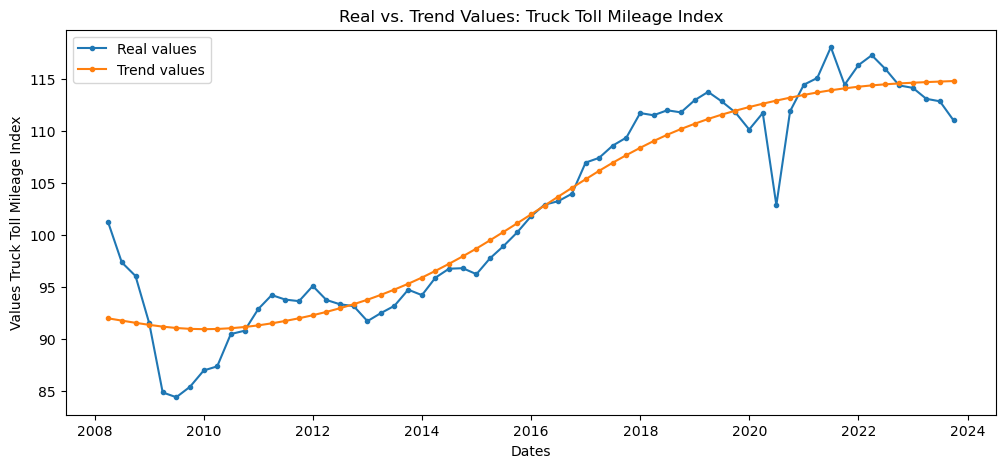

In [7]:
# Plotting the trend values compared to the real values
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
fig, ax = plt.subplots()
ax.plot(df_test.index,df_test["values"], label="Real values", marker=".")
ax.plot(df_test.index,df_test["trend_values"], label="Trend values", marker=".")
plt.xlabel('Dates')
plt.ylabel('Values Truck Toll Mileage Index')
plt.title('Real vs. Trend Values: Truck Toll Mileage Index')
plt.legend()
plt.show()

Now I will try to create a similar trend series for the daily data. As a general reference point I will use the [Ravn & Uhlig formula](https://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf).

In [17]:
lambda_value=5.75*365**4 # Ravn & Uhlig suggest a value of 6.25 instead of 5.75.
df["cycle_values"], df["trend_values"] = sm.tsa.filters.hpfilter(df["values"].values, lamb=lambda_value) # using the hp filter
print(lambda_value) # printing lambda value
df # printing out the new dataframe with trend and cycle values

102056178593.75


,values,cycle_values,trend_values
date,,,
2008-01-01,83.8,-8.443893,92.243893
2008-01-02,111.7,19.458784,92.241216
2008-01-03,112.6,20.361460,92.238540
2008-01-04,104.2,11.964136,92.235864
2008-01-05,83.3,-8.933187,92.233187
...,...,...,...
2023-08-08,106.4,-8.763639,115.163639
2023-08-09,106.7,-8.464609,115.164609
2023-08-10,106.4,-8.765580,115.165580


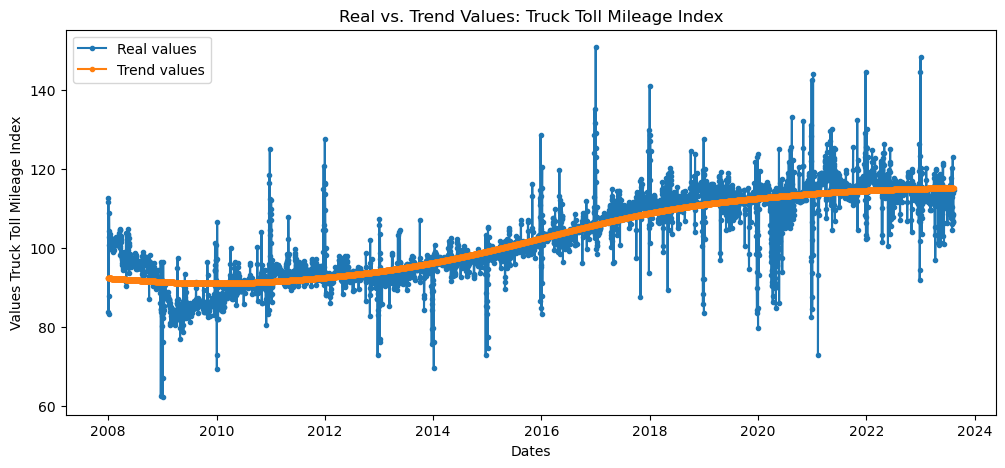

In [9]:
# Plotting trend and real values
fig, ax = plt.subplots()
ax.plot(df.index,df["values"], label="Real values", marker=".")
ax.plot(df.index,df["trend_values"], label="Trend values", marker=".")
plt.xlabel('Dates')
plt.ylabel('Values Truck Toll Mileage Index')
plt.title('Real vs. Trend Values: Truck Toll Mileage Index')
plt.legend()
plt.show()

When we compare the two trend series graphically, we can see that they are almost identical. Therefore, the choice of the lambda values seems fine.

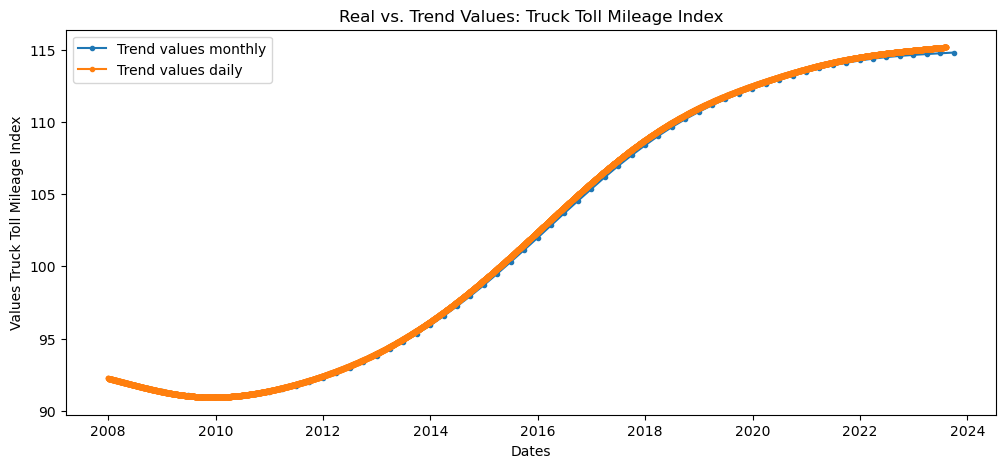

In [10]:
fig, ax = plt.subplots()
ax.plot(df_test.index,df_test["trend_values"], label="Trend values monthly", marker=".")
ax.plot(df.index,df["trend_values"], label="Trend values daily", marker=".")
plt.xlabel('Dates')
plt.ylabel('Values Truck Toll Mileage Index')
plt.title('Real vs. Trend Values: Truck Toll Mileage Index')
plt.legend()
plt.show()

We can also compare the two trend series for the time period that I will analyze. Again, both series are almost identical.

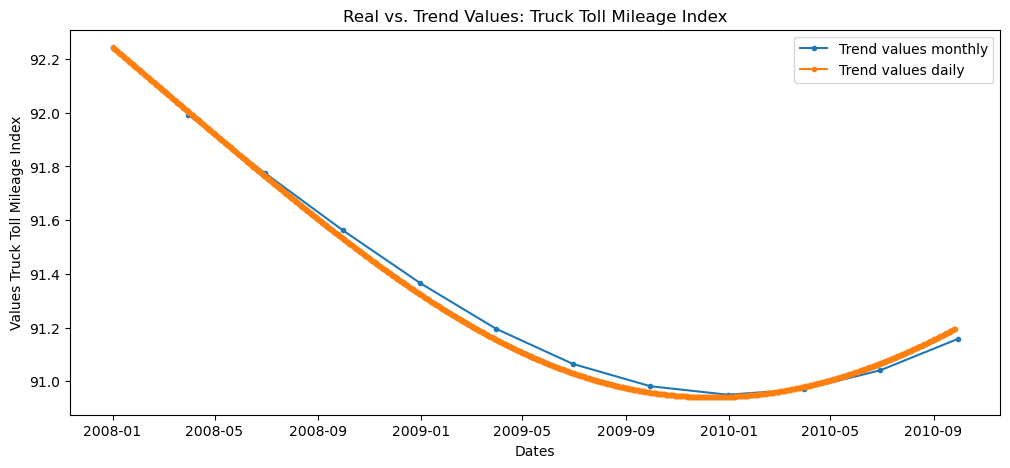

In [11]:
fig, ax = plt.subplots()
ax.plot(df_test.index[:11],df_test["trend_values"][:11], label="Trend values monthly", marker=".")
ax.plot(df.index[:1000],df["trend_values"][:1000], label="Trend values daily", marker=".")
plt.xlabel('Dates')
plt.ylabel('Values Truck Toll Mileage Index')
plt.title('Real vs. Trend Values: Truck Toll Mileage Index')
plt.legend()
plt.show()

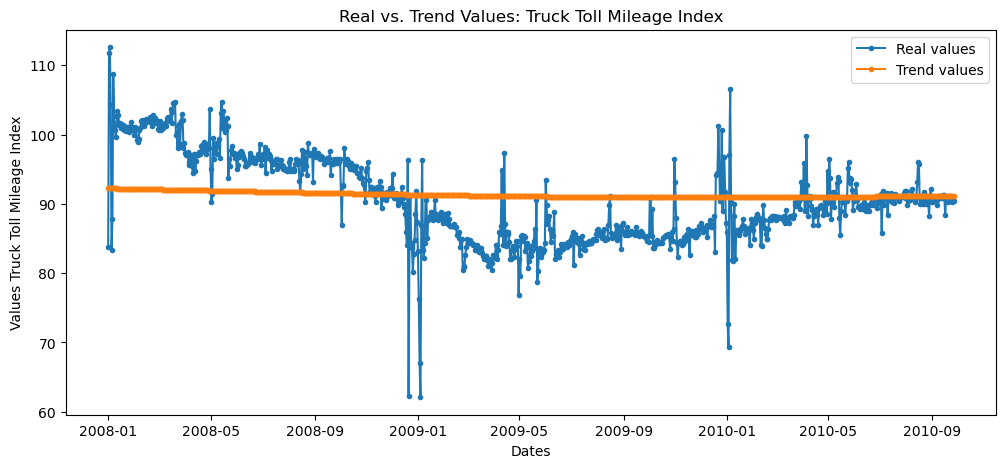

In [12]:
fig, ax = plt.subplots()
ax.plot(df.index[0:1000],df["values"][0:1000], label="Real values", marker=".")
ax.plot(df.index[0:1000],df["trend_values"][0:1000], label="Trend values", marker=".")
plt.xlabel('Dates')
plt.ylabel('Values Truck Toll Mileage Index')
plt.title('Real vs. Trend Values: Truck Toll Mileage Index')
plt.legend()
plt.show()

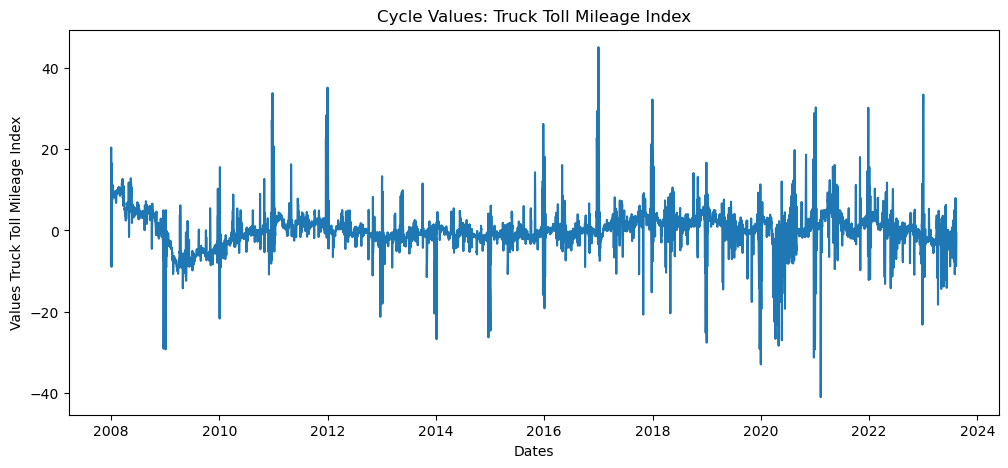

In [13]:
# Plotting the cycle values of the truck toll mileage index
fig, ax = plt.subplots()
ax.plot(df.index,df["cycle_values"])
plt.xlabel('Dates')
plt.ylabel('Values Truck Toll Mileage Index')
plt.title('Cycle Values: Truck Toll Mileage Index')
plt.show()

In [14]:
# Calculating the mean of the cycle values
df["cycle_values"].mean()

-9.407741814185877e-05

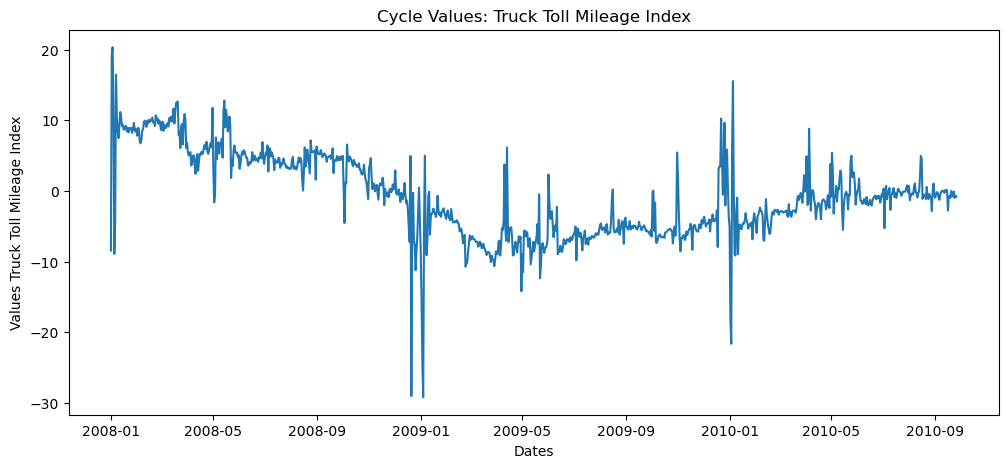

In [15]:
# Plotting the cycle values of the truck toll mileage index for the examined period
fig, ax = plt.subplots()
ax.plot(df.index[0:1000], df["cycle_values"][0:1000])
plt.xlabel('Dates')
plt.ylabel('Values Truck Toll Mileage Index')
plt.title('Cycle Values: Truck Toll Mileage Index')
plt.show()

In [16]:
# Calculating the mean of the cycle values of the examined time period
df["cycle_values"][0:1000].mean()

-0.7126650061395359

### Sentiment Analysis Model

Next, I will classify the sentiment of the headlines by using a sentiment analysis model from the huggingface server. The model that I will be using is the [multilingual_sentiment_newspaper_headlines model by Zachary Dickson](https://huggingface.co/z-dickson/multilingual_sentiment_newspaper_headlines?text=Deutsche+Wirtschaft+schrumpft+2023+um+bis+zu+0%2C5+Prozent). The model is a fine-tuned bert-base-multilingual-cased model that was fine-tuned on a set of 30 thousand headlines including headlines from Germany, Poland, Spain, England and the Netherlands. 

In [10]:
# Importing all the additional modules and libraries that I will need for this section
from transformers import AutoTokenizer, TextClassificationPipeline, AutoModelForSequenceClassification, logging, TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
import ast
from datasets import Dataset, DatasetDict

In [11]:
# Importing the model and the tokenizer that belongs to the model
tokenizer = AutoTokenizer.from_pretrained("z-dickson/multilingual_sentiment_newspaper_headlines")
model = AutoModelForSequenceClassification.from_pretrained("z-dickson/multilingual_sentiment_newspaper_headlines",
                                                           from_tf=True) # from_tf=True has to be defined since the original model was build using tensorflow
# Creating a classification pipeline
sentiment_classifier = TextClassificationPipeline(tokenizer=tokenizer,
                                                  model=model,
                                                 device="cuda:0" if torch.cuda.is_available() else None) # setting the device to GPU if availabel

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [12]:
# Testing the model on a few examples
text = ["Benazir bhuttos sohn: Hoffnungsträger zwischen Comics und Kino", "Lohnverhandlungen: 2008 wird ein Jahr mit harten Tarifrunden", "Versand: Otto ist wieder vollständig in Familienbesitz", "Drittes reich: Die Presse glaubte nicht an Hitlers Aufstieg", "Hessen-wahlkampf: Ypsilanti wirft Koch Ausländer-Kampagne vor", "Usa: Neue Umfrage sieht Obama vor Clinton", "Unruhen in kenia: Mob zündet Kirche mit Frauen und Kindern an", "Gewalt: Jugendliche schlagen zwei Männer zusammen", "Pakistan: Plante Benazir Bhutto brisante Enthüllungen?", "Leipzig: Straßenschlachten in der Silvesternacht", "Nach bhutto-mord: Die Wahlen in Pakistan werden verschoben", "Kolumbien: Freilassung von drei Geiseln vorerst gescheitert", "Erziehungscamps: Bosbach attackiert Justizministerin Zypries", "Blutige proteste: Zahl der Toten in Kenia steigt auf über 200"]
result = sentiment_classifier(text)
result

[{'label': 'neutral', 'score': 0.544023871421814},
 {'label': 'neutral', 'score': 0.610117495059967},
 {'label': 'positive', 'score': 0.7351326942443848},
 {'label': 'neutral', 'score': 0.982966423034668},
 {'label': 'neutral', 'score': 0.6054152250289917},
 {'label': 'neutral', 'score': 0.6659818887710571},
 {'label': 'negative', 'score': 0.9972884654998779},
 {'label': 'negative', 'score': 0.9574436545372009},
 {'label': 'negative', 'score': 0.9989606142044067},
 {'label': 'positive', 'score': 0.6996238827705383},
 {'label': 'negative', 'score': 0.9981850981712341},
 {'label': 'negative', 'score': 0.9989144802093506},
 {'label': 'negative', 'score': 0.8317199945449829},
 {'label': 'negative', 'score': 0.9989113807678223}]

Next, I will test some code that calculates the mean value of all the sentiment labels of a specific day. I will then use this code in a function to get a overall sentiment label for all examined days.

In [13]:
# Define a mapping from labels to integers
label_mapping = {'negative': 1, 'neutral': 2, 'positive': 3}

# Convert the labels to integers
label_integers = [label_mapping[item['label']] for item in result]

# Calculate the mean of the label integers
mean_label = sum(label_integers) / len(label_integers)

print("Mean Label (as integers):", mean_label)

Mean Label (as integers): 1.6428571428571428


Now, I will define the function that I will be using to analyze the sentiment of my headlines dataframe. 

In [14]:
def analyze_sentiment(df, model, tokenizer, text_to_analyze):
    # Creating classification pipeline
    sentiment_classifier = TextClassificationPipeline(tokenizer=tokenizer,
                                                      model=model,
                                                     device="cuda:0" if torch.cuda.is_available() else None) # Setting device to GPU if available
    
    # Creating new columns for the dataset
    df["sentiment"]=None
    df["sentiment_per_element"]=None
    df["sentiment_score_per_element"]=None
    # Creating a loop that loops through all the rows of the dataframe
    for index in df.index:
        result=sentiment_classifier(df.loc[index, text_to_analyze]) # classifying all the headlines of one day and storing the values in the result variable
        label_mapping = {'negative': 1, 'neutral': 2, 'positive': 3} # changing the labels to their numerical equivalents to calculate the mean for the entire day
        label_integers = [label_mapping[item['label']] for item in result]
        label_scores = [item["score"] for item in result] # saving the scores for each individual label of each individal headlines in the label_scores variable
        mean_label = sum(label_integers) / len(label_integers) # Calculating the mean label for a specific day
        # Storing all the values in the respective columns
        df.loc[index,"sentiment"]=mean_label
        df.at[index, "sentiment_per_element"] = label_integers  # Use 'at' method
        df.at[index, "sentiment_score_per_element"]= label_scores
    return df

I will now use the newly created function to analyze the sentiment of all the headlines of my dataframe.

In [15]:
location_headlines="headlines in a list"
headline_df=analyze_sentiment(headline_df,model,tokenizer,location_headlines)
headline_df

,headlines,headlines in a list,sentiment,sentiment_per_element,sentiment_score_per_element
headlines date,,,,,
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...,1.642857,"[2, 2, 3, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1]","[0.544023871421814, 0.610117495059967, 0.73513..."
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...,1.90625,"[3, 3, 2, 2, 2, 2, 1, 2, 3, 1, 2, 2, 3, 2, 2, ...","[0.8193055391311646, 0.42256566882133484, 0.74..."
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...,1.695652,"[2, 3, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 3, 1, ...","[0.9034836292266846, 0.509800374507904, 0.7017..."
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...,1.666667,"[3, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, ...","[0.6588568687438965, 0.9981132745742798, 0.774..."
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...,1.722222,"[1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 3, 2, 2, 2, 3, ...","[0.8558867573738098, 0.7723591923713684, 0.957..."
2008-01-06,Georgien: Staatschef Saakaschwili als Wahlsieg...,[Georgien: Staatschef Saakaschwili als Wahlsie...,2.076923,"[2, 1, 3, 2, 2, 2, 3, 1, 3, 1, 1, 3, 3]","[0.6819856762886047, 0.9864466190338135, 0.719..."
2008-01-07,Vor new hampshire: Plötzlich war Hillary Clint...,[Vor new hampshire: Plötzlich war Hillary Clin...,1.870968,"[2, 2, 1, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 1, 3, ...","[0.7184631824493408, 0.9393197298049927, 0.977..."
2008-01-08,Usa: Hohe Beteiligung an US-Vorwahl in New Ham...,[Usa: Hohe Beteiligung an US-Vorwahl in New Ha...,1.793103,"[1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 1, ...","[0.6518973708152771, 0.863184928894043, 0.9918..."
2008-01-09,Wahlkampf: CSU geht mit Prügelszene auf Stimme...,[Wahlkampf: CSU geht mit Prügelszene auf Stimm...,1.74359,"[2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 3, 1, 2, 2, 2, ...","[0.9034368395805359, 0.9007635116577148, 0.862..."


In [16]:
# Changing the number of decimal places for the score column
decimal_places = 2  # Change this to the desired number of decimal places

# Define a custom function to round each element within a list
def round_scores(score_list):
    return [round(score, decimal_places) for score in score_list]

# Apply the custom function to the 'scores' column
headline_df['sentiment_score_per_element'] = headline_df['sentiment_score_per_element'].apply(round_scores)

headline_df

,headlines,headlines in a list,sentiment,sentiment_per_element,sentiment_score_per_element
headlines date,,,,,
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...,1.642857,"[2, 2, 3, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1]","[0.54, 0.61, 0.74, 0.98, 0.61, 0.67, 1.0, 0.96..."
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...,1.90625,"[3, 3, 2, 2, 2, 2, 1, 2, 3, 1, 2, 2, 3, 2, 2, ...","[0.82, 0.42, 0.75, 0.97, 0.96, 0.97, 1.0, 0.81..."
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...,1.695652,"[2, 3, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 3, 1, ...","[0.9, 0.51, 0.7, 1.0, 0.95, 0.96, 0.56, 0.6, 0..."
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...,1.666667,"[3, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, ...","[0.66, 1.0, 0.77, 0.7, 0.84, 0.67, 1.0, 0.93, ..."
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...,1.722222,"[1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 3, 2, 2, 2, 3, ...","[0.86, 0.77, 0.96, 1.0, 0.99, 0.53, 0.58, 1.0,..."
2008-01-06,Georgien: Staatschef Saakaschwili als Wahlsieg...,[Georgien: Staatschef Saakaschwili als Wahlsie...,2.076923,"[2, 1, 3, 2, 2, 2, 3, 1, 3, 1, 1, 3, 3]","[0.68, 0.99, 0.72, 0.98, 0.54, 0.94, 0.8, 0.83..."
2008-01-07,Vor new hampshire: Plötzlich war Hillary Clint...,[Vor new hampshire: Plötzlich war Hillary Clin...,1.870968,"[2, 2, 1, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 1, 3, ...","[0.72, 0.94, 0.98, 0.62, 0.72, 1.0, 0.67, 0.63..."
2008-01-08,Usa: Hohe Beteiligung an US-Vorwahl in New Ham...,[Usa: Hohe Beteiligung an US-Vorwahl in New Ha...,1.793103,"[1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 1, ...","[0.65, 0.86, 0.99, 0.6, 0.68, 0.99, 0.73, 1.0,..."
2008-01-09,Wahlkampf: CSU geht mit Prügelszene auf Stimme...,[Wahlkampf: CSU geht mit Prügelszene auf Stimm...,1.74359,"[2, 1, 2, 1, 3, 1, 3, 3, 2, 3, 3, 1, 2, 2, 2, ...","[0.9, 0.9, 0.86, 1.0, 0.68, 0.55, 0.62, 0.68, ..."


In [ ]:
# Outcommenting these lines saves the dataframe as the csv file
#output_file_path = ROOT/'listofheadlinesssentimentanalyzed.csv'
#headline_df.to_csv(output_file_path, index=True, sep="|") 

Once again, in case you want to skip the labeling part, you can use the following lines to import the data into the notebook. Furthermore, I used this saved dataframe to later on compare the forecasts made when using the zero-shot classification labels compared to the fine-tuned model labels. The results of this comparison will be mentioned in the results section of the README.md file.

In [13]:
# In case you do not want to do the sentiment labeling, you can just import the dataset with the following code:
output_file_path = DATA_FOLDER/'listofheadlinesssentimentanalyzed.csv'
headline_df=pd.read_csv(output_file_path, index_col=0, sep="|")
# Split the concatenated strings in the 'headlines in a list' column to recreate lists
headline_df['headlines in a list'] = headline_df['headlines in a list'].apply(ast.literal_eval)
headline_df.index = pd.to_datetime(headline_df.index)
headline_df

,headlines,headlines in a list,sentiment,sentiment_per_element,sentiment_score_per_element
headlines date,,,,,
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...,1.642857,"[2, 2, 3, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1]","[0.54, 0.61, 0.74, 0.98, 0.61, 0.67, 1.0, 0.96..."
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...,1.906250,"[3, 3, 2, 2, 2, 2, 1, 2, 3, 1, 2, 2, 3, 2, 2, ...","[0.82, 0.42, 0.75, 0.97, 0.96, 0.97, 1.0, 0.81..."
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...,1.695652,"[2, 3, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 3, 1, ...","[0.9, 0.51, 0.7, 1.0, 0.95, 0.96, 0.56, 0.6, 0..."
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...,1.666667,"[3, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, ...","[0.66, 1.0, 0.77, 0.7, 0.84, 0.67, 1.0, 0.93, ..."
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...,1.722222,"[1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 3, 2, 2, 2, 3, ...","[0.86, 0.77, 0.96, 1.0, 0.99, 0.53, 0.58, 1.0,..."
...,...,...,...,...,...
2010-09-22,Nach absturz: Polen fordert Trümmer von Präsid...,[Nach absturz: Polen fordert Trümmer von Präsi...,1.454545,"[1, 1, 3, 1, 2, 2, 3, 2, 2, 1, 1, 1, 3, 1, 1, ...","[1.0, 1.0, 0.77, 0.64, 0.85, 0.91, 0.86, 0.72,..."
2010-09-23,Un-vollversammlung: Irans Präsident löst in Ne...,[Un-vollversammlung: Irans Präsident löst in N...,1.730769,"[1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 2, 2, ...","[1.0, 0.51, 0.97, 1.0, 1.0, 1.0, 0.97, 0.74, 0..."
2010-09-24,Nach uno-eklat: Obama attackiert Ahmadinedscha...,[Nach uno-eklat: Obama attackiert Ahmadinedsch...,1.725000,"[1, 3, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 1, 1, ...","[1.0, 0.91, 0.97, 0.41, 0.94, 1.0, 1.0, 0.62, ..."


One can use the query function to investigate the newly created dataframe. As we can see most of the overall sentiment label values are above 1.5, but below 2.0 so in absolute labels would be classified as neutral, but slightly negative.

In [53]:
print(headline_df.query("sentiment > 1.5"))

Empty DataFrame
Columns: [headlines, headlines in a list, sentiment, sentiment_per_element, sentiment_score_per_element]
Index: []


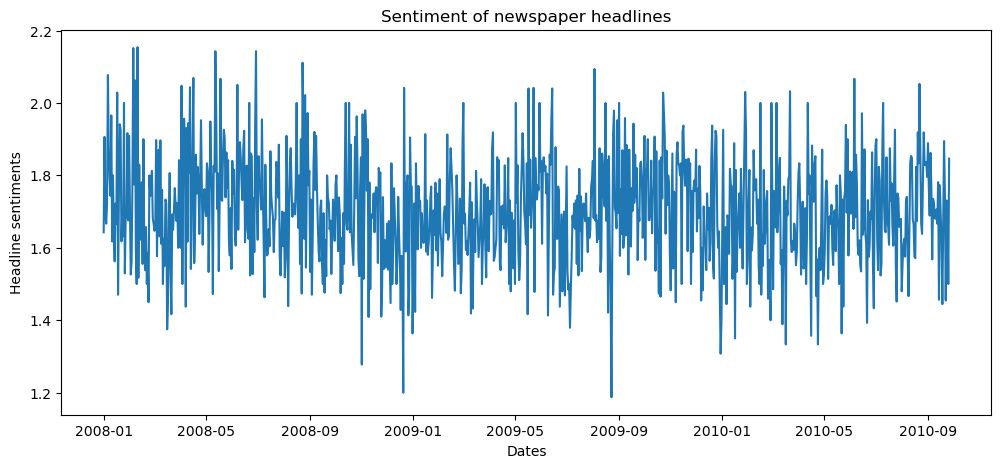

In [18]:
# Plotting the newly created daily overall seniment label value
fig, ax = plt.subplots()
ax.plot(headline_df.index,headline_df["sentiment"])
plt.xlabel('Dates')
plt.ylabel('Headline sentiments')
plt.title('Sentiment of newspaper headlines')
plt.show()

As one can see in the graph above, the sentiment label values seem to also behave like a cyle value would do if staying around a specific mean and briefly diverting from it in both directions. This is a promising sign, however, definetely not a guarantee that the forecast will, therfore, produce good results.

Lastly, for this unfine-tuned zero-shot classification model, I will compare the daily overall labels of this model with my hand-labeled labels.

In [154]:
input_path_handlabel= DATA_FOLDER/"newspaperheadlines_manually_labeled.xlsx"
handlabled_df=pd.read_excel(input_path_handlabel, index_col=0, nrows=30)
label_mapping = {
    "negative": 1,
    "neutral": 2,
    "positive": 3
}
handlabled_df['label'] = handlabled_df['sentiment manually label'].map(label_mapping)
handlabled_df

,headlines,sentiment manually label,label
headlines date,,,
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,negative,1
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,neutral,2
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,neutral,2
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,positive,3
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,negative,1
2008-01-06,Georgien: Staatschef Saakaschwili als Wahlsieg...,negative,1
2008-01-07,Vor new hampshire: Plötzlich war Hillary Clint...,negative,1
2008-01-08,Usa: Hohe Beteiligung an US-Vorwahl in New Ham...,neutral,2
2008-01-09,Wahlkampf: CSU geht mit Prügelszene auf Stimme...,negative,1


In [166]:
y_pred_daily=headline_df["sentiment"][:30]
y_pred_daily

headlines date
2008-01-01    1.642857
2008-01-02    1.906250
2008-01-03    1.695652
2008-01-04    1.666667
2008-01-05    1.722222
2008-01-06    2.076923
2008-01-07    1.870968
2008-01-08    1.793103
2008-01-09    1.743590
2008-01-10    1.965517
2008-01-11    1.617647
2008-01-12    1.800000
2008-01-13    1.625000
2008-01-14    1.562500
2008-01-15    1.722222
2008-01-16    1.666667
2008-01-17    2.028571
2008-01-18    1.470588
2008-01-19    1.750000
2008-01-20    1.941176
2008-01-21    1.925926
2008-01-22    1.617647
2008-01-23    1.700000
2008-01-24    1.631579
2008-01-25    2.000000
2008-01-26    1.529412
2008-01-27    1.681818
2008-01-28    1.684211
2008-01-29    1.916667
2008-01-30    1.675676
Name: sentiment, dtype: float64

In [158]:
y_test_daily=handlabled_df["label"]
y_test_daily

headlines date
2008-01-01    1
2008-01-02    2
2008-01-03    2
2008-01-04    3
2008-01-05    1
2008-01-06    1
2008-01-07    1
2008-01-08    2
2008-01-09    1
2008-01-10    1
2008-01-11    1
2008-01-12    2
2008-01-13    2
2008-01-14    2
2008-01-15    1
2008-01-16    1
2008-01-17    1
2008-01-18    1
2008-01-19    1
2008-01-20    2
2008-01-21    2
2008-01-22    2
2008-01-23    2
2008-01-24    3
2008-01-25    2
2008-01-26    1
2008-01-27    2
2008-01-28    2
2008-01-29    2
2008-01-30    1
Name: label, dtype: int64

In [167]:
mse_daily_zeroshot= mean_squared_error(y_test_daily, y_pred_daily)
print("The mean squared error for the sentiment labels of the zero-shot-classification model is", mse_daily_zeroshot)

The mean squared error for the sentiment labels of the zero-shot-classification model is 0.42947626323346116


At next, I will try to fine-tune the model to see if I can improve the score of the headlines compared to my manually labeled labels.

First, I will seperate all the headlines so I can label them on their own. Then I will save the file so I can label it manually again and then fine-tune it on that dataset.

In [16]:
headline_df_seperated = headline_df.explode('headlines in a list', ignore_index=True)
headline_df_seperated=headline_df_seperated["headlines in a list"]
headline_df_seperated

0        Benazir bhuttos sohn: Hoffnungsträger zwischen...
1        Lohnverhandlungen: 2008 wird ein Jahr mit hart...
2        Versand: Otto ist wieder vollständig in Famili...
3        Drittes reich: Die Presse glaubte nicht an Hit...
4        Hessen-wahlkampf: Ypsilanti wirft Koch Ausländ...
                               ...                        
33555    Linksruck: SPD fordert Spitzensteuersatz von 4...
33556    Enttäuschung: Magere Wirtschaftsbilanz von Sch...
33557    Israels siedlungsbau: USA bemühen sich um Rett...
33558    Wahl in venezuela: Chávez dringt auf noch mehr...
33559    Erstaunliche interviews: Fidel Castro entpuppt...
Name: headlines in a list, Length: 33560, dtype: object

In [10]:
# Saving the dataset for hand-labeling
output_file_path = DATA_FOLDER/'headlinesdatasetfinetuning.xlsx'
headline_df_seperated.to_excel(output_file_path, index=False)

In [8]:
# Importing the hand-labeled dataset back into the notebook
input_file_path= DATA_FOLDER/"headlinesdatasetfinetuninghandlabeled.xlsx"
headlinesdatasetfinetuning= pd.read_excel(input_file_path,sheet_name=0, usecols="A,B",skiprows=1392, header=None, names=["text","label"], nrows=300)
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Map the labels using the defined mapping to change the string labels to their numerical equivalent.
headlinesdatasetfinetuning['label'] = headlinesdatasetfinetuning['label'].map(label_mapping)
headlinesdatasetfinetuning

,text,label
0,Kreditkrise: US-Notenbank senkt Wachtumsprogno...,0
1,Job-programme: 100.000 Stellen versprochen – 7...,0
2,Vor der hamburg-wahl: Naumann will alles sein ...,1
3,Luftverkehr: Russische Behörden sperren Luftha...,0
4,Übernahmekampf: Yahoo macht sich noch teurer,1
...,...,...
295,Teuerung: Studiengebühren treiben Preise in De...,0
296,Afghanistan-einsatz: Obama will Deutsche an di...,1
297,Computerhersteller: Ziemlich große Delle im Ge...,0
298,Us-versicherer: Der größte Verlust in der Firm...,0


In [18]:
# Splitting dataframe into test and validation set
train_df = headlinesdatasetfinetuning.sample(frac=0.666666666, random_state=5)
validation_df = headlinesdatasetfinetuning.drop(train_df.index)
test_df = validation_df.sample(frac=0.5, random_state=56)
validation_df = validation_df.drop(test_df.index)

# Create a dictionary with the train and validation splits
data_dict = {
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(validation_df),
    "test": Dataset.from_pandas(test_df)
}

# Remove the index level column "__index_level_0__" from each dataset within data_dict. This is the index from the pandas dataframe which I no longer need. Therefore, I will drop it.
if "__index_level_0__" in data_dict["train"].column_names:
    data_dict["train"] = data_dict["train"].remove_columns("__index_level_0__")

if "__index_level_0__" in data_dict["validation"].column_names:
    data_dict["validation"] = data_dict["validation"].remove_columns("__index_level_0__")

if "__index_level_0__" in data_dict["test"].column_names:
    data_dict["test"] = data_dict["test"].remove_columns("__index_level_0__")

# Convert to a DatasetDict
dataset_dict_headlines = DatasetDict(data_dict)
dataset_dict_headlines

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

Next, I will monitor how the zero-shot classification model performs on the validation and test data to then compare the performance to the fine-tuned model.

In [68]:
model_output = pd.DataFrame(sentiment_classifier(dataset_dict_headlines["validation"]["text"]))
replacements = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}
y_pred = model_output["label"].replace(replacements).to_numpy()
y_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1], dtype=int64)

In [69]:
y_eval = np.array(dataset_dict_headlines["validation"]["label"])
y_eval

array([1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1,
       0, 1, 2, 1, 0, 0])

In [70]:
# Creating classification report for the zero-shot classification model
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.75      0.55        16
           1       0.61      0.41      0.49        27
           2       0.50      0.29      0.36         7

    accuracy                           0.50        50
   macro avg       0.51      0.48      0.47        50
weighted avg       0.54      0.50      0.49        50



In [149]:
# Creating confusion matrix for the zero-shot classification model
confusion_zeroshot=confusion_matrix(y_eval, y_pred, normalize="true")
confusion=pd.DataFrame(confusion_zeroshot, columns=["negative","neutral", "positive"],
                       index = ["negative", "neutral", "positive"])
print(confusion)

          negative   neutral  positive
negative  0.750000  0.250000  0.000000
neutral   0.518519  0.407407  0.074074
positive  0.285714  0.428571  0.285714


In [124]:
# Doing the same procedure for the test data
model_output = pd.DataFrame(sentiment_classifier(dataset_dict_headlines["test"]["text"]))
y_pred_test = model_output["label"].replace(replacements).to_numpy()
y_pred_test

array([1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 2,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 1, 2, 1, 1, 1, 0, 0, 2,
       1, 0, 0, 0, 1, 1], dtype=int64)

In [125]:
y_test = np.array(dataset_dict_headlines["test"]["label"])
y_test

array([0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 0, 0, 1, 0])

In [126]:
# Again, printing the classication report for the test data
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.36      0.69      0.47        13
           1       0.53      0.28      0.36        29
           2       0.40      0.50      0.44         8

    accuracy                           0.42        50
   macro avg       0.43      0.49      0.43        50
weighted avg       0.47      0.42      0.41        50



In [ ]:
# Creating confusion matrix for the zero-shot classification model
confusion_zeroshot=confusion_matrix(y_test, y_pred_test, normalize="true")
confusion=pd.DataFrame(confusion_zeroshot, columns=["negative","neutral", "positive"],
                       index = ["negative", "neutral", "positive"])
print(confusion)

In the next part of this section, I will fine-tune the model using the training and evaluation data created earlier and then compare the performance results of both models on the evaluation and test data.

In [19]:
# Define a function that tokenizes the data in batches
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Tokenizing the entire dataset dictionary
headlines_encoded = dataset_dict_headlines.map(tokenize, batched=True, batch_size=None)
# Setting format to torch for the fine-tuning process
headlines_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"],
)
headlines_encoded.set_format("torch")
# Printing out the newly created data
headlines_encoded

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
})

One newly created column that cannot be found when tokenizing data using different models, but can be found when using a Bert model is the token type ids. The token type ids are used by Bert models to sort texts into different segments (e.g. sentences). This is done to seperate different words and tokens from different segements or sentences of the text from each other similar to the attention mask that distinguishes actual tokens from padding tokens. Since I am only analyzing each headline on their one, the token type ids should also be zero since there is always only one sentence that is analyzed.

In [13]:
headlines_encoded["train"]["token_type_ids"][:] # as one can see all are zero

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
model_name="z-dickson/multilingual_sentiment_newspaper_headlines"
num_labels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # saving the type of processing unit in the device variable
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels, from_tf=True # loading the model again
).to(device)

At next, for the training process, I will define the training arguments and then train model. Before that I have to define a metrics function that computes the metric on which the model will then be evaluated.

In [14]:
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=-1) # computing predictions
    f1 = f1_score(labels, preds, average="macro") # setting the f1-score to the macro f1-score due to imbalanced data
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [15]:
batch_size = 50
logging_steps = len(headlines_encoded["train"]) // batch_size # defining logging steps
model_directory= ROOT/"model"

training_args = TrainingArguments(
    output_dir=model_directory , # exporting the model into the right directory
    optim="adamw_torch", # using adam as the optimizer for the training
    per_device_train_batch_size=batch_size, # setting batch size
    num_train_epochs=1, # setting the number of train epochs to 1 to avoid overfitting
    load_best_model_at_end=True,
    metric_for_best_model="f1", # using the macro f1-score as the metric due to imbalanced data
    evaluation_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
)

NameError: name 'headlines_encoded' is not defined

In [140]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=headlines_encoded["train"],
    eval_dataset=headlines_encoded["validation"],
)

In [141]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.846100,0.905508,0.680000,0.597252
2,0.555500,0.858818,0.680000,0.579128


TrainOutput(global_step=8, training_loss=0.7008431851863861, metrics={'train_runtime': 103.907, 'train_samples_per_second': 3.85, 'train_steps_per_second': 0.077, 'total_flos': 4933376582400.0, 'train_loss': 0.7008431851863861, 'epoch': 2.0})

In [142]:
# Loading the newly created model and creating a new text-classification pipeline for the model
model_path = model_directory/"checkpoint-4"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
finetuned_classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, framework="pt")
# Again, testing the model on the same text as before:
text = ["Benazir bhuttos sohn: Hoffnungsträger zwischen Comics und Kino", "Lohnverhandlungen: 2008 wird ein Jahr mit harten Tarifrunden", "Versand: Otto ist wieder vollständig in Familienbesitz", "Drittes reich: Die Presse glaubte nicht an Hitlers Aufstieg", "Hessen-wahlkampf: Ypsilanti wirft Koch Ausländer-Kampagne vor", "Usa: Neue Umfrage sieht Obama vor Clinton", "Unruhen in kenia: Mob zündet Kirche mit Frauen und Kindern an", "Gewalt: Jugendliche schlagen zwei Männer zusammen", "Pakistan: Plante Benazir Bhutto brisante Enthüllungen?", "Leipzig: Straßenschlachten in der Silvesternacht", "Nach bhutto-mord: Die Wahlen in Pakistan werden verschoben", "Kolumbien: Freilassung von drei Geiseln vorerst gescheitert", "Erziehungscamps: Bosbach attackiert Justizministerin Zypries", "Blutige proteste: Zahl der Toten in Kenia steigt auf über 200"]
result = finetuned_classifier(text)
result

[{'label': 'neutral', 'score': 0.8242040872573853},
 {'label': 'neutral', 'score': 0.8028944730758667},
 {'label': 'neutral', 'score': 0.6689855456352234},
 {'label': 'neutral', 'score': 0.972756564617157},
 {'label': 'neutral', 'score': 0.8036524653434753},
 {'label': 'neutral', 'score': 0.8538421392440796},
 {'label': 'negative', 'score': 0.6409309506416321},
 {'label': 'neutral', 'score': 0.5096287727355957},
 {'label': 'negative', 'score': 0.8851425051689148},
 {'label': 'neutral', 'score': 0.656566858291626},
 {'label': 'negative', 'score': 0.7183708548545837},
 {'label': 'negative', 'score': 0.9185563325881958},
 {'label': 'neutral', 'score': 0.6804816722869873},
 {'label': 'negative', 'score': 0.8746615648269653}]

Now, I will investigate the performance of the newly fine-tuned model compared to the zero-shot classification model using the same metrics.

In [143]:
model_output = pd.DataFrame(finetuned_classifier(dataset_dict_headlines["validation"]["text"]))
y_pred_finetuned = model_output["label"].replace(replacements).to_numpy()
y_pred_finetuned

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1], dtype=int64)

In [135]:
y_eval = np.array(dataset_dict_headlines["validation"]["label"])
y_eval

array([1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1,
       0, 1, 2, 1, 0, 0])

In [87]:
# Printing the classification report from the zero-shot classification model as a comparison to the fine-tuned model
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.75      0.55        16
           1       0.61      0.41      0.49        27
           2       0.50      0.29      0.36         7

    accuracy                           0.50        50
   macro avg       0.51      0.48      0.47        50
weighted avg       0.54      0.50      0.49        50



In [144]:
# Printing the classification report of the newly fine-tuned model
print(classification_report(y_eval, y_pred_finetuned))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58        16
           1       0.70      0.85      0.77        27
           2       1.00      0.29      0.44         7

    accuracy                           0.68        50
   macro avg       0.77      0.57      0.60        50
weighted avg       0.71      0.68      0.66        50



In [145]:
confusion_zeroshot=confusion_matrix(y_eval, y_pred_finetuned, normalize="true")
confusion=pd.DataFrame(confusion_zeroshot, columns=["negative","neutral", "positive"],
                       index = ["negative", "neutral", "positive"])
print(confusion)

          negative   neutral  positive
negative  0.562500  0.437500  0.000000
neutral   0.148148  0.851852  0.000000
positive  0.285714  0.428571  0.285714


I will evaluate the performance of the newly fine-tuned model in the results section of the README.md file.

In [146]:
# Now doing the same procedure for the test data
model_output = pd.DataFrame(finetuned_classifier(dataset_dict_headlines["test"]["text"]))
y_pred_test_finetuned = model_output["label"].replace(replacements).to_numpy()
y_pred_test_finetuned

array([1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1], dtype=int64)

In [115]:
y_test = np.array(dataset_dict_headlines["test"]["label"])
y_test

array([0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 0, 0, 1, 0])

In [127]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.36      0.69      0.47        13
           1       0.53      0.28      0.36        29
           2       0.40      0.50      0.44         8

    accuracy                           0.42        50
   macro avg       0.43      0.49      0.43        50
weighted avg       0.47      0.42      0.41        50



In [147]:
print(classification_report(y_test, y_pred_test_finetuned))

              precision    recall  f1-score   support

           0       0.42      0.38      0.40        13
           1       0.61      0.69      0.65        29
           2       0.60      0.38      0.46         8

    accuracy                           0.56        50
   macro avg       0.54      0.48      0.50        50
weighted avg       0.56      0.56      0.55        50



In [148]:
confusion_zeroshot=confusion_matrix(y_test, y_pred_test_finetuned, normalize="true")
confusion=pd.DataFrame(confusion_zeroshot, columns=["negative","neutral", "positive"],
                       index = ["negative", "neutral", "positive"])
print(confusion)

          negative   neutral  positive
negative  0.384615  0.615385  0.000000
neutral   0.241379  0.689655  0.068966
positive  0.000000  0.625000  0.375000


In the next part of this section, I will now use the fine-tuned model to analyze the sentiment of all the headlines from my dataframe. The function is the same as the function that used the zero-shot classification just with the new text-classification pipeline of the new fine-tuned model.

In [ ]:
def analyze_sentiment(df, model, tokenizer, text_to_analyze):
    sentiment_classifier = TextClassificationPipeline(tokenizer=tokenizer,
                                                      model=model,
                                                      framework="pt",
                                                     device="cuda:0" if torch.cuda.is_available() else None)
    df["sentiment"]=None
    df["sentiment_per_element"]=None
    df["sentiment_score_per_element"]=None
    for index in df.index:
        result=sentiment_classifier(df.loc[index, text_to_analyze])
        label_mapping = {'negative': 1, 'neutral': 2, 'positive': 3}
        label_integers = [label_mapping[item['label']] for item in result]
        label_scores = [item["score"] for item in result]
        mean_label = sum(label_integers) / len(label_integers)
        df.loc[index,"sentiment"]=mean_label
        df.at[index, "sentiment_per_element"] = label_integers  # Use 'at' method
        df.at[index, "sentiment_score_per_element"]= label_scores
    return df

In [ ]:
location_headlines="headlines in a list"
headline_df=analyze_sentiment(headline_df,model,tokenizer,location_headlines)
headline_df

In [ ]:
fig, ax = plt.subplots()
ax.plot(headline_df.index,headline_df["sentiment"])
plt.xlabel('Dates')
plt.ylabel('Headline sentiments')
plt.title('Sentiment of newspaper headlines')
plt.show()

Again, we can similar cycle-like behaviour from our sentiment label values as could be seen when using the zero-shot classification model.

In [ ]:
# Again, the query function can be used to analyze the newly created sentiment label values
headline_df.query("sentiment>=2")

In [ ]:
# Changing the number of decimal places for the score column
decimal_places = 2  # Change this to the desired number of decimal places

# Define a custom function to round each element within a list
def round_scores(score_list):
    return [round(score, decimal_places) for score in score_list]

# Apply the custom function to the 'scores' column
headline_df['sentiment_score_per_element'] = headline_df['sentiment_score_per_element'].apply(round_scores)

headline_df

In [ ]:
# Outcommenting these lines saves the dataframe as the csv file
output_file_path = ROOT/'listofheadlinesssentimentanalyzed2.csv'
headline_df.to_csv(output_file_path, index=True, sep="|")

In [23]:
# In case you do not want to do the sentiment labeling, you can just import the dataset with the following code:
output_file_path = DATA_FOLDER/'listofheadlinesssentimentanalyzed2.csv'
headline_df=pd.read_csv(output_file_path, index_col=0, sep="|")
# Split the concatenated strings in the 'headlines in a list' column to recreate lists
headline_df['headlines in a list'] = headline_df['headlines in a list'].apply(ast.literal_eval)
headline_df.index = pd.to_datetime(headline_df.index)
headline_df

,headlines,headlines in a list,sentiment,sentiment_per_element,sentiment_score_per_element
headlines date,,,,,
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...,1.571429,"[2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1]","[0.78, 0.59, 0.67, 0.96, 0.66, 0.8, 0.77, 0.69..."
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...,1.718750,"[2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, ...","[0.63, 0.44, 0.69, 0.93, 0.92, 0.96, 0.72, 0.8..."
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...,1.608696,"[2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, ...","[0.95, 0.82, 0.71, 0.96, 0.61, 0.65, 0.93, 0.5..."
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...,1.703704,"[2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, ...","[0.6, 0.88, 0.8, 0.85, 0.93, 0.73, 0.77, 0.91,..."
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...,1.611111,"[2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, ...","[0.55, 0.9, 0.6, 0.66, 0.56, 0.81, 0.72, 0.83,..."
...,...,...,...,...,...
2010-09-22,Nach absturz: Polen fordert Trümmer von Präsid...,[Nach absturz: Polen fordert Trümmer von Präsi...,1.613636,"[1, 1, 3, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 1, 1, ...","[0.77, 0.91, 0.6, 0.56, 0.85, 0.85, 0.79, 0.83..."
2010-09-23,Un-vollversammlung: Irans Präsident löst in Ne...,[Un-vollversammlung: Irans Präsident löst in N...,1.615385,"[1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, ...","[0.91, 0.59, 0.92, 0.7, 0.9, 0.71, 0.52, 0.5, ..."
2010-09-24,Nach uno-eklat: Obama attackiert Ahmadinedscha...,[Nach uno-eklat: Obama attackiert Ahmadinedsch...,1.800000,"[1, 3, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 1, 1, ...","[0.86, 0.56, 0.46, 0.51, 0.93, 0.82, 0.94, 0.8..."


Lastly, I will compare the performance of the fine-tuned model when analyzing the overall daily sentiment of all the headlines from one day as I did before with the zero-shot classification model.

In [163]:
y_pred_daily_finetuned=headline_df["sentiment"][:30]
y_pred_daily_finetuned

headlines date
2008-01-01    1.571429
2008-01-02    1.718750
2008-01-03    1.608696
2008-01-04    1.703704
2008-01-05    1.611111
2008-01-06    1.846154
2008-01-07    1.774194
2008-01-08    1.827586
2008-01-09    1.743590
2008-01-10    1.827586
2008-01-11    1.676471
2008-01-12    1.900000
2008-01-13    1.625000
2008-01-14    1.656250
2008-01-15    1.722222
2008-01-16    1.641026
2008-01-17    1.914286
2008-01-18    1.441176
2008-01-19    1.666667
2008-01-20    2.000000
2008-01-21    1.740741
2008-01-22    1.588235
2008-01-23    1.800000
2008-01-24    1.552632
2008-01-25    1.687500
2008-01-26    1.529412
2008-01-27    1.681818
2008-01-28    1.657895
2008-01-29    1.791667
2008-01-30    1.621622
Name: sentiment, dtype: float64

In [164]:
mse_daily_finetuned= mean_squared_error(y_test_daily, y_pred_daily_finetuned)
print("The mean squared error for the sentiment labels of the zero-shot-classification model is", mse_daily_finetuned)

The mean squared error for the sentiment labels of the zero-shot-classification model is 0.3909026982594713


I will analyze this result in the results section of the README.md file.

### Forecasting economic activity using sentiment labels of headlines

Next, I will use the newly gathered sentiment labels of the headlines that I have scraped to forecast economic activity using the indicator that I have imported and prepared before.
The forecasting models that I will be using are a VAR or VARMA (Vector-Auto-Regressive-Moving-Average) Model as well as an XGBoost Model and an ARMA-Model as a baseline model. 

In [18]:
from statsmodels.tsa.stattools import adfuller # advanced dickey-fuller (ADF) test for testing for stationarity
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR # vector-auto-regressive (VAR) models
from statsmodels.tsa.statespace.varmax import VARMAX # vector-auto-regressive moving-average (VARMA) models with exogenous data (X)
from statsmodels.tools.eval_measures import aic # akaike information criterion
from numpy import log
import pmdarima as pm # pmdarima is a special model constructed for optimally using ARIMA models. It is based on the statsmodels and sklearn libraries 
from pmdarima.model_selection import train_test_split # similar to sklearns train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, EstimationWarning

#### ARIMA model
First, I will train a baseline ARIMA model as a comparison to the other two models.

To train a baseline ARIMA model, I first have to split the data and test whether the data is stationary or not. Based on the advanced dickey-fuller (ADF) test the time-series is not stationary. However, since this mostly the case due to the specific time horizon that I chose I will still not differentiate the values and therefore choose a value of 0 for d in the ARIMA(p,d,q) model.
I also tried fitting a model with d=1 and it almost performed the same as with d=0.

In [19]:
train, test = train_test_split(df["cycle_values"][0:1000], train_size=975)

In [20]:
# First check if our time-series is stationary
result = adfuller(train.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.239932
p-value: 0.192073


As we can see here our time-series is not stationary. This is caused by the time period that I chose in which there is a (slight) downward sloping trend visible.

In [21]:
ARIMAmodel = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',# use adftest to find optimal 'd'. Should be 0 in our case.
                      max_p=15, max_q=15, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # Choosing d=0 since the overall time horizon of the values is stationary
                      seasonal=False,   # No Seasonality (The series that I'm using has already been "deseasoned".)
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(ARIMAmodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4862.731, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6251.000, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4993.781, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5533.285, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4991.615, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4745.915, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5325.867, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4746.481, Time=0.37 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4745.835, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5217.628, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4745.148, Time=0.58 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4741.505, Time=0.80 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4739.520, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4737.537, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[0]          

As can be seen in the table above, all the p-values of the lags and moving-average components are significant for the ARMA model.

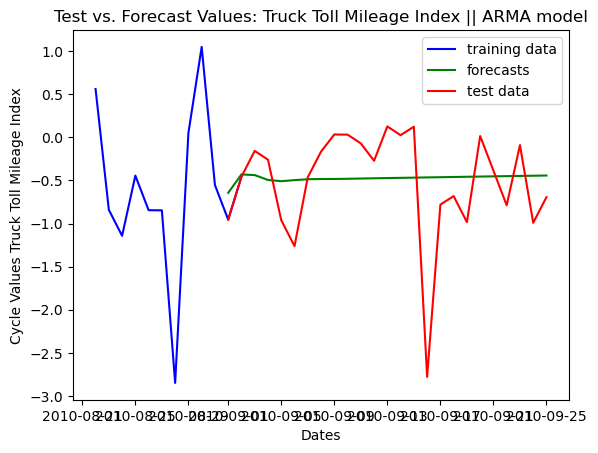

In [31]:
# making forecasts
ARIMA_forecasts = ARIMAmodel.predict(25)  # predict into the future
RESULTS_FOLDER= ROOT/"results"

# Visualize the forecasts (blue=train, green=forecasts, red=test)
plt.plot(df.index[964:976], df["cycle_values"][964:976] , label="training data", c="blue")
plt.plot(df.index[974:999], ARIMA_forecasts, label="forecasts", c="green")
plt.plot(df.index[974:999], df["cycle_values"][974:999], label="test data", c="red")
plt.xlabel('Dates')
plt.ylabel('Cycle Values Truck Toll Mileage Index')
plt.title('Test vs. Forecast Values: Truck Toll Mileage Index || ARMA model')
plt.legend()
plt.savefig(RESULTS_FOLDER/'ARMA_forecasts_cycle.png', bbox_inches='tight')
plt.show()

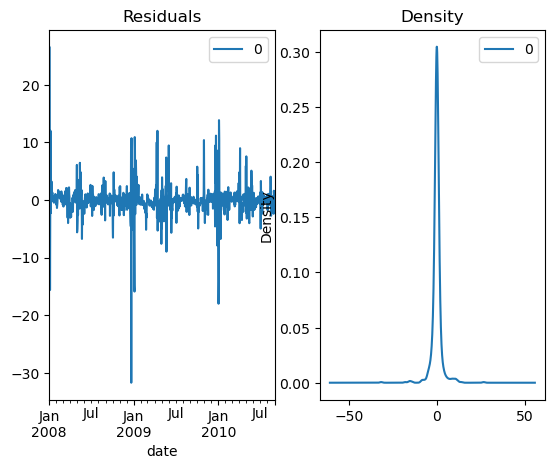

In [219]:
# Plot residual errors
residuals = pd.DataFrame(ARIMAmodel.resid())
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [182]:
msearima=mean_squared_error(test[:6], ARIMA_forecasts[:6])
print(f"The Mean Squared Error from the ARIMA model is equal to: {msearima}")

The Mean Squared Error from the ARIMA model is equal to: 0.15462392772933434


#### VAR model
Now, I will implement the VAR-model using the labels from the sentiment analysis model as the second variable.

First, we will merge the two dataframes into one.

In [24]:
merged_df = headline_df.merge(df, left_index=True, right_index=True, how='inner')
merged_df

,headlines,headlines in a list,sentiment,sentiment_per_element,sentiment_score_per_element,values,cycle_values,trend_values
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...,1.571429,"[2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1]","[0.78, 0.59, 0.67, 0.96, 0.66, 0.8, 0.77, 0.69...",83.8,-8.443893,92.243893
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...,1.718750,"[2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, ...","[0.63, 0.44, 0.69, 0.93, 0.92, 0.96, 0.72, 0.8...",111.7,19.458784,92.241216
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...,1.608696,"[2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, ...","[0.95, 0.82, 0.71, 0.96, 0.61, 0.65, 0.93, 0.5...",112.6,20.361460,92.238540
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...,1.703704,"[2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, ...","[0.6, 0.88, 0.8, 0.85, 0.93, 0.73, 0.77, 0.91,...",104.2,11.964136,92.235864
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...,1.611111,"[2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, ...","[0.55, 0.9, 0.6, 0.66, 0.56, 0.81, 0.72, 0.83,...",83.3,-8.933187,92.233187
...,...,...,...,...,...,...,...,...
2010-09-22,Nach absturz: Polen fordert Trümmer von Präsid...,[Nach absturz: Polen fordert Trümmer von Präsi...,1.613636,"[1, 1, 3, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 1, 1, ...","[0.77, 0.91, 0.6, 0.56, 0.85, 0.85, 0.79, 0.83...",90.4,-0.788095,91.188095
2010-09-23,Un-vollversammlung: Irans Präsident löst in Ne...,[Un-vollversammlung: Irans Präsident löst in N...,1.615385,"[1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, ...","[0.91, 0.59, 0.92, 0.7, 0.9, 0.71, 0.52, 0.5, ...",91.1,-0.089755,91.189755
2010-09-24,Nach uno-eklat: Obama attackiert Ahmadinedscha...,[Nach uno-eklat: Obama attackiert Ahmadinedsch...,1.800000,"[1, 3, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 1, 1, ...","[0.86, 0.56, 0.46, 0.51, 0.93, 0.82, 0.94, 0.8...",90.2,-0.991420,91.191420
2010-09-25,Vollversammlung: Westerwelles peinlicher Versp...,[Vollversammlung: Westerwelles peinlicher Vers...,1.642857,"[1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, ...","[0.87, 0.87, 0.45, 0.79, 0.43, 0.66, 0.65, 0.8...",90.5,-0.693090,91.193090


Next, I should normally differentiate our training data once since it is not stationary by the advanced-dickey-fuller (ADF) test and VAR assumes stationarity. However, I found that the VAR model without the one-time differentation performs better than with differentiating it once. Additionally the time-series is only non-stationary for the chosen time horizon and quickly becomes stationary once I choose a longer time-horizon. Therefore, I am going to keep the time-series slightly under-differentiated.

In [25]:
cycle_train, cycle_test, sentiment_train, sentiment_test = train_test_split(merged_df["cycle_values"], merged_df["sentiment"], train_size=975)
# As one can see from the ADF-test the time-series is not stationary
result = adfuller(cycle_train.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# When we increase the time horizon, however, it very quickly becomes stationary
result = adfuller(df["cycle_values"][:1200].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# The whole series is most-definetely stationary
result = adfuller(df["cycle_values"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.239932
p-value: 0.192073
ADF Statistic: -2.924181
p-value: 0.042607
ADF Statistic: -6.096717
p-value: 0.000000


After splitting the data into test and training data, I will convert the training data into a pandas dataframe (just for convience).

In [26]:
cycle_train_df = pd.DataFrame(cycle_train)
sentiment_train_df=pd.DataFrame(sentiment_train)
train_merged_df = cycle_train_df.merge(sentiment_train_df, left_index=True, right_index=True, how='inner')
train_merged_df

,cycle_values,sentiment
2008-01-01,-8.443893,1.571429
2008-01-02,19.458784,1.718750
2008-01-03,20.361460,1.608696
2008-01-04,11.964136,1.703704
2008-01-05,-8.933187,1.611111
...,...,...
2010-08-28,-2.848205,1.857143
2010-08-29,0.050260,1.875000
2010-08-30,1.048720,1.720930
2010-08-31,-0.552826,1.734694


Next, I have to choose the order which my VAR model should have.

In [27]:
model= VAR(train_merged_df, freq="D")
x= model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.8183,-0.8082,0.4412,-0.8145
1,-2.226,-2.196,0.1079,-2.215
2,-2.257,-2.206,0.1047,-2.237
3,-2.358,-2.287,0.09458,-2.331
4,-2.380,-2.289,0.09252,-2.346
5,-2.413,-2.301*,0.08958,-2.370
6,-2.425,-2.293,0.08846,-2.375
7,-2.442,-2.290,0.08700,-2.384*
8,-2.441,-2.269,0.08704,-2.376
9,-2.452,-2.260,0.08609,-2.379


Since the Akaike Information Criterion (AIC) and the Final Prediction Error (FPE) suggest a model with 9 lags, I will choose a VAR(9) model.

In [28]:
model_fit_VAR=model.fit(maxlags=14)
model_fit_VAR.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Sep, 2023
Time:                     18:34:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.17266
Nobs:                     961.000    HQIC:                  -2.35458
Log likelihood:          -1484.07    FPE:                  0.0848879
AIC:                     -2.46646    Det(Omega_mle):       0.0799875
--------------------------------------------------------------------
Results for equation cycle_values
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -4.221060         3.302853           -1.278           0.201
L1.cycle_values          0.522871         0.032751           15.965           0.000
L1.sentiment             1.376397        

As we can see from the table above, quite a few p-values of the lags from the cycle values, but also from the sentiment label values are signifcant for the cycle value. Much fewer p-values are significant for the sentiment label value indicating that the model seems to have more issues in forecasting the sentiment label value rather than the cycle values which one probably could have expected.

At next, I will forecast the next twenty-five steps into the future and save the forecasts in a pandas dataframe.

In [29]:
forecast = model_fit_VAR.forecast(train_merged_df.values, steps=25)  # Use all values for forecasting and predict 25 steps into the future
columns = ['forecast_cycle_values', 'forecast_sentiment']
forecast_df = pd.DataFrame(forecast, columns=columns, index=merged_df.index[975:])
forecast_df

,forecast_cycle_values,forecast_sentiment
2010-09-02,-0.624483,1.686185
2010-09-03,-0.688533,1.723876
2010-09-04,-0.571892,1.742065
2010-09-05,-0.200534,1.724412
2010-09-06,-0.429079,1.709764
2010-09-07,-0.511043,1.696117
2010-09-08,-0.363404,1.707234
2010-09-09,-0.315479,1.711251
2010-09-10,-0.833811,1.710985
2010-09-11,-0.920204,1.727279


Now, I will visualize both forecasts in comparison to the actual values.

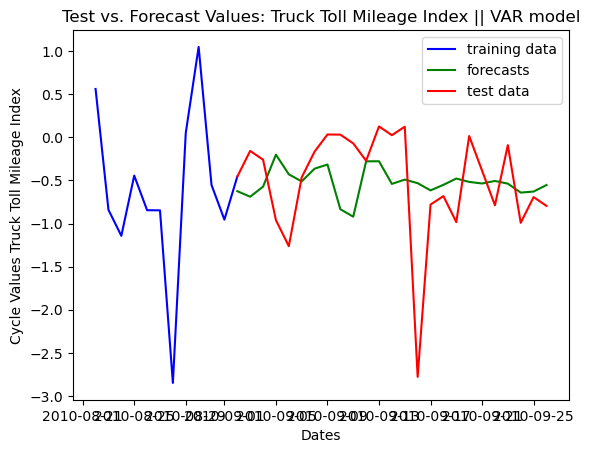

In [32]:
# Visualize the forecasts (blue=train, green=forecasts, red=test)
plt.plot(merged_df.index[964:976], merged_df["cycle_values"][964:976] , label="training data", c="blue")
plt.plot(forecast_df.index[:25], forecast_df["forecast_cycle_values"][:25], label="forecasts", c="green")
plt.plot(merged_df.index[975:1000], merged_df["cycle_values"][975:1000], label="test data", c="red")
plt.xlabel('Dates')
plt.ylabel('Cycle Values Truck Toll Mileage Index')
plt.title('Test vs. Forecast Values: Truck Toll Mileage Index || VAR model')
plt.legend()
plt.savefig(RESULTS_FOLDER/'VAR_forecasts_cycle.png', bbox_inches='tight')
plt.show()

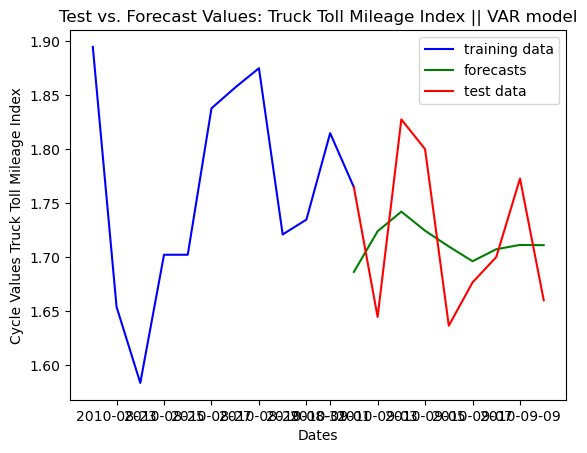

In [174]:
# Visualize the forecasts (blue=train, green=forecasts, red=test)
plt.plot(merged_df.index[964:976], merged_df["sentiment"][964:976] , label="training data", c="blue")
plt.plot(forecast_df.index[:9], forecast_df["forecast_sentiment"][:9], label="forecasts", c="green")
plt.plot(merged_df.index[975:984], merged_df["sentiment"][975:984], label="test data", c="red")
plt.xlabel('Dates')
plt.ylabel('Cycle Values Truck Toll Mileage Index')
plt.title('Test vs. Forecast Values: Truck Toll Mileage Index || VAR model')
plt.legend()
plt.savefig(RESULTS_FOLDER/'VAR_forecasts_sentiment.png', bbox_inches='tight')
plt.show()

(Again, I will speak about these graphs in the result section of the README.file)

Next, I will calcalute the mean squared error of both forecasts.

In [181]:
mse_cycle_values_VAR = mean_squared_error(test[:6], forecast_df["forecast_cycle_values"][:6])
print(f"The Mean Squared Error of the cycle values forecasts from the VAR model is equal to: {mse_cycle_values_VAR}")

The Mean Squared Error of the cycle values forecasts from the VAR model is equal to: 0.28039255485847997


In [27]:
mse_sentiment_values_VAR = mean_squared_error(merged_df["sentiment"][975:], forecast_df["forecast_sentiment"][:25])
print(f"The Mean Squared Error of the sentiment values from the VAR model is equal to: {mse_sentiment_values_VAR}")

The Mean Squared Error of the sentiment values from the VAR model is equal to: 0.00784704104763337


I also tried to model a VARMA model so a VAR model with a moving-average component, but I found that the best performing model was a model without any moving-average components.
Below you can find the code that I used to investigate different VARMA models.

Again, in theory, we should differentiate the values that we are using for the VARMA model, but I found that the model works better without the differentation especially since the downward-sloping trend is mostly something that can be found in the observed time period and quickly fades as we add a longer horizon to the ADF-test as shown before.

In [28]:
# This is the code that could be used to differentiate the cycle values
#train_merged_df["cycle_values"][1:]=train_merged_df["cycle_values"].diff().dropna()
#train_merged_df=train_merged_df[1:] # we need to drop the first value of the dataframe since it is not possible to differentiate this value
#result = adfuller(train_merged_df["cycle_values"].values)
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
#train_merged_df

Next, since there is no select_order function for VARMA models I wrote a for-loop that tests different VARMA model with different orders and selects the best-performing one based one the AIC and the BIC respectively. (Note: The execution of this code can take quite a long time based on the amount of possible lags one chooses.)

In [29]:
# Loop through different orders and calculate AIC/BIC
max_lags=6
max_ma_component=6
orders = [(p, q) for p in range(0,max_lags+1) for q in range(0,max_ma_component+1)] # This line creates all possible orders based on the maximum number
# of lags and moving-average components chosen
if orders[0]==(0,0):
    orders=orders[1:] # Since an order of (0,0) is not allowed. I remove this order.

aic_bic = []
warnings.simplefilter('ignore', ConvergenceWarning) # hide convergence warning
warnings.simplefilter('ignore', EstimationWarning) # hide estimation warning


for order in orders:
    model = VARMAX(train_merged_df, freq="D", order=order) # select the model
    results = model.fit() # fit the model to the data
    aic, bic = results.aic, results.bic # store the values of the Information Criteria
    aic_bic.append((order, aic, bic))


# Find the order with the lowest AIC and BIC
best_order_aic = min(aic_bic, key=lambda x: x[1]) # find the order with the lowest value in the second element of the list (this is the value of the AIC)
print("Best Order AIC:", best_order_aic)
best_order_bic= min(aic_bic, key=lambda x: x[2]) # find the order with the lowest value in the third element of the list (this is the value of the BIC)
print("Best Order BIC:", best_order_bic)
aic_bic #print out the values for all investigated orders

Best Order AIC: ((6, 0), 3317.0578322340325, 3458.64851889297)
Best Order BIC: ((1, 2), 3342.0668688622245, 3425.068305869188)


[((0, 1), 4074.217327850144, 4118.159265089124),
 ((0, 2), 3932.712974149638, 3996.18466127261),
 ((0, 3), 3927.137377916545, 4010.1388149235086),
 ((0, 4), 3955.3342963111245, 4057.8654832020793),
 ((0, 5), 3909.86526942733, 4031.9262062022763),
 ((0, 6), 3937.421383708628, 4079.0120703675657),
 ((1, 0), 3535.096498549631, 3579.038435788612),
 ((1, 1), 3418.7385879426665, 3482.2102750656386),
 ((1, 2), 3342.0668688622245, 3425.068305869188),
 ((1, 3), 3395.8043516202406, 3498.3355385111954),
 ((1, 4), 3399.7875907998596, 3521.8485275748058),
 ((1, 5), 3392.975565158048, 3534.5662518169856),
 ((1, 6), 3398.4778766733407, 3559.5983132162696),
 ((2, 0), 3519.669472315609, 3583.141159438581),
 ((2, 1), 3448.1972113137294, 3531.198648320693),
 ((2, 2), 3350.464094694613, 3452.9952815855677),
 ((2, 3), 3342.038148159354, 3464.0990849343),
 ((2, 4), 3361.0420935092125, 3502.63278016815),
 ((2, 5), 3329.6650603498924, 3490.7854968928214),
 ((2, 6), 3344.1124483683893, 3524.7626347953096),
 ((

As we can see, the best performing model based on the AIC is a VARMA(14,0) or VAR(14) model and the best peforming model based on the BIC is a VARMA(1,2) model. However, when one tries to forecast with these models the VAR(14) model clearly is better than the VARMA(1,2) model.


***Note:*** (It should be noted that the results of the VAR module and the VARMAX module of the statsmodels library are not the same for the same model (e.g. VAR(14) and VARMAX(14,0)) since they use a different approach for estimation. The VAR module fits VAR models via conditional maximum likelihood (i.e. least squares) and the VARMAX modules fits VARMAX models via exact maximum likelihood.
One will generally not get the same coefficients, for two reasons:
1. Conditional MLE is only asymptotically the same as exact MLE
2. The maximum likelihood estimates in VARMAX are found numerically, and there may be difficulties finding the maximum and / or there may be numerical noise.)

In [35]:
model = VARMAX(train_merged_df, order=(1, 2), freq="D")
VARMA_model = model.fit()
VARMA_model.summary()

C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['cycle_values', 'sentiment']",No. Observations:,975
Model:,"VARMA(1,2)",Log Likelihood,-1654.033
,+ intercept,AIC,3342.067
Date:,"Sun, 10 Sep 2023",BIC,3425.068
Time:,18:36:47,HQIC,3373.652
Sample:,01-01-2008,,
,- 09-01-2010,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.02, 6.32",Jarque-Bera (JB):,"31659.96, 0.01"
Prob(Q):,"0.90, 0.01",Prob(JB):,"0.00, 0.99"
Heteroskedasticity (H):,"1.14, 0.92",Skew:,"-0.29, 0.01"


Here are the forecasts of the VARMA(1,2) model.

In [36]:
VARMA_forecasts = VARMA_model.predict(start=len(train_merged_df), end=len(train_merged_df)+24)
VARMA_forecasts

,cycle_values,sentiment
2010-09-02,0.204362,1.705500
2010-09-03,0.585605,1.693201
2010-09-04,0.606582,1.679211
2010-09-05,0.592253,1.677273
2010-09-06,0.573466,1.676997
2010-09-07,0.554469,1.676951
2010-09-08,0.535838,1.676937
2010-09-09,0.517642,1.676928
2010-09-10,0.499884,1.676920
2010-09-11,0.482552,1.676911


Here is the visualization of the forecasts compared to the actual data.

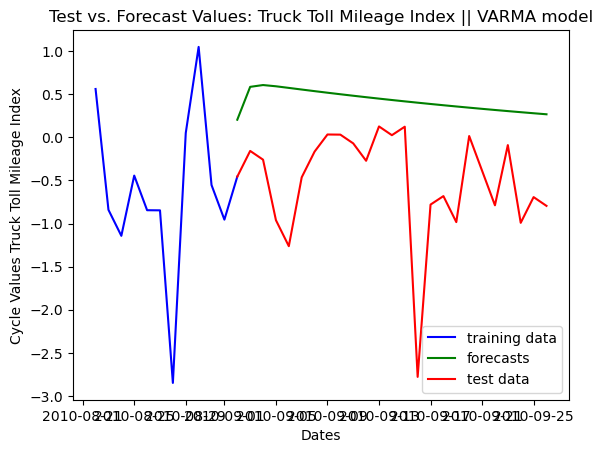

In [37]:
# Visualize the forecasts (blue=train, green=forecasts, red=test)
plt.plot(merged_df.index[964:976], merged_df["cycle_values"][964:976] , label="training data", c="blue")
plt.plot(VARMA_forecasts.index[:25], VARMA_forecasts["cycle_values"][:25], label="forecasts", c="green")
plt.plot(merged_df.index[975:1000], merged_df["cycle_values"][975:1000], label="test data", c="red")
plt.xlabel('Dates')
plt.ylabel('Cycle Values Truck Toll Mileage Index')
plt.title('Test vs. Forecast Values: Truck Toll Mileage Index || VARMA model')
plt.legend()
plt.savefig(RESULTS_FOLDER/'VARMA_forecasts_cycle.png', bbox_inches='tight')
plt.show()

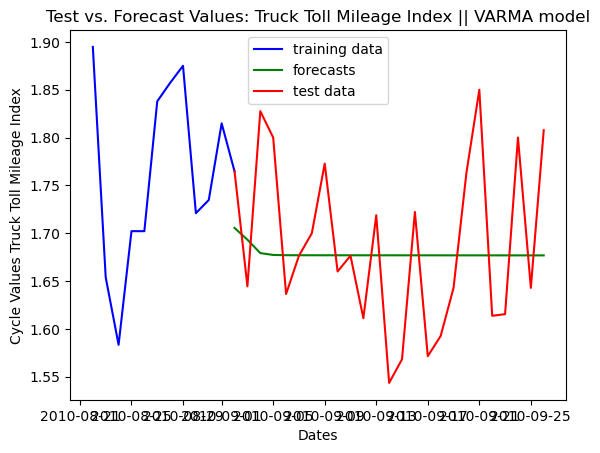

In [38]:
# Visualize the forecasts (blue=train, green=forecasts, red=test)
plt.plot(merged_df.index[964:976], merged_df["sentiment"][964:976] , label="training data", c="blue")
plt.plot(VARMA_forecasts.index[:25], VARMA_forecasts["sentiment"][:25], label="forecasts", c="green")
plt.plot(merged_df.index[975:1000], merged_df["sentiment"][975:1000], label="test data", c="red")
plt.xlabel('Dates')
plt.ylabel('Cycle Values Truck Toll Mileage Index')
plt.title('Test vs. Forecast Values: Truck Toll Mileage Index || VARMA model')
plt.legend()
plt.savefig(RESULTS_FOLDER/'VARMA_forecasts_sentiment.png', bbox_inches='tight')
plt.show()

As one can see, the VARMA(1,2) model does not perform well at all when being used for forecasting the cycle values. The mean squared error shows us the same.

In [39]:
mse_cycle_VARMA = mean_squared_error(merged_df["cycle_values"][975:978], VARMA_forecasts["cycle_values"][:3])
print(f"The Mean Squared Error from the VARMA model is equal to: {mse_cycle_VARMA}")

The Mean Squared Error from the VARMA model is equal to: 0.5791719783431702


Nevertheless, the mean squared error for the sentiment value forecasts is slightly better compared to the mean squared error of the VAR forecasts. 

In [40]:
mse_sentiment_VARMA=mean_squared_error(merged_df["sentiment"][975:], VARMA_forecasts["sentiment"])
print(f"The Mean Squared Error from the VARMA model for the sentiment labels is equal to: {mse_sentiment_VARMA}")

The Mean Squared Error from the VARMA model for the sentiment labels is equal to: 0.007615629326959567


#### XGBoost Model
Next, I will implement an XGBoost model using again the two variables from before to compare a more novel approach to forecasting to two more sophisticated approaches. It should be noted, however, that this approach is not quite comparable to the other approaches since I use the XGBoost model to do one step forecasts rather than multi-step forecasts which I use for the auto-regressive models.

***Note:*** I was sadly not able to finish this section before the deadline. Therefore, the model is rather incomplete. Nevertheless, this sort of my first attempt at designing a XGBoost model for forecasting time-series data.

In [55]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

I will also create a couple of features for the XGBoost model since they might be useful for the decision tree creation of the XGBoost model.

In [56]:
merged_df["day of the week"]=merged_df.index.day_of_week
merged_df["month"]=merged_df.index.month
merged_df["quarter"]=merged_df.index.quarter
merged_df["year"]=merged_df.index.year
merged_df

,headlines,headlines in a list,sentiment,sentiment_per_element,sentiment_score_per_element,values,cycle_values,trend_values,day of the week,month,quarter,year
2008-01-01,Benazir bhuttos sohn: Hoffnungsträger zwischen...,[Benazir bhuttos sohn: Hoffnungsträger zwische...,1.571429,"[2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1]","[0.78, 0.59, 0.67, 0.96, 0.66, 0.8, 0.77, 0.69...",83.8,-8.443893,92.243893,1,1,1,2008
2008-01-02,Fdp: Wolfgang Gerhardts Angriff auf die eigene...,[Fdp: Wolfgang Gerhardts Angriff auf die eigen...,1.718750,"[2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, ...","[0.63, 0.44, 0.69, 0.93, 0.92, 0.96, 0.72, 0.8...",111.7,19.458784,92.241216,2,1,1,2008
2008-01-03,Diplomatie: Iran wünscht bessere Beziehungen z...,[Diplomatie: Iran wünscht bessere Beziehungen ...,1.608696,"[2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, ...","[0.95, 0.82, 0.71, 0.96, 0.61, 0.65, 0.93, 0.5...",112.6,20.361460,92.238540,3,1,1,2008
2008-01-04,Kriminalität: NRW richtet Camp für jugendliche...,[Kriminalität: NRW richtet Camp für jugendlich...,1.703704,"[2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, ...","[0.6, 0.88, 0.8, 0.85, 0.93, 0.73, 0.77, 0.91,...",104.2,11.964136,92.235864,4,1,1,2008
2008-01-05,Vowahlen in new hampshire: Hillary Clintons Vo...,[Vowahlen in new hampshire: Hillary Clintons V...,1.611111,"[2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, ...","[0.55, 0.9, 0.6, 0.66, 0.56, 0.81, 0.72, 0.83,...",83.3,-8.933187,92.233187,5,1,1,2008
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-09-22,Nach absturz: Polen fordert Trümmer von Präsid...,[Nach absturz: Polen fordert Trümmer von Präsi...,1.613636,"[1, 1, 3, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 1, 1, ...","[0.77, 0.91, 0.6, 0.56, 0.85, 0.85, 0.79, 0.83...",90.4,-0.788095,91.188095,2,9,3,2010
2010-09-23,Un-vollversammlung: Irans Präsident löst in Ne...,[Un-vollversammlung: Irans Präsident löst in N...,1.615385,"[1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, ...","[0.91, 0.59, 0.92, 0.7, 0.9, 0.71, 0.52, 0.5, ...",91.1,-0.089755,91.189755,3,9,3,2010
2010-09-24,Nach uno-eklat: Obama attackiert Ahmadinedscha...,[Nach uno-eklat: Obama attackiert Ahmadinedsch...,1.800000,"[1, 3, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 1, 1, ...","[0.86, 0.56, 0.46, 0.51, 0.93, 0.82, 0.94, 0.8...",90.2,-0.991420,91.191420,4,9,3,2010
2010-09-25,Vollversammlung: Westerwelles peinlicher Versp...,[Vollversammlung: Westerwelles peinlicher Vers...,1.642857,"[1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, ...","[0.87, 0.87, 0.45, 0.79, 0.43, 0.66, 0.65, 0.8...",90.5,-0.693090,91.193090,5,9,3,2010


In [57]:
FEATURES= ["sentiment","day of the week", "month", "quarter", "year"]# These columns are going to be my features for the XGBoost model to be trained on

In [58]:
X_train, X_test, y_train, y_test = train_test_split(merged_df[FEATURES][:975], merged_df["cycle_values"][:975],
                                                    test_size=0.25,
                                                    random_state=None,
                                                    shuffle=False) # due to my data being time-series data I do not want the train and test data to be
                                                    # random
y_train

2008-01-01    -8.443893
2008-01-02    19.458784
2008-01-03    20.361460
2008-01-04    11.964136
2008-01-05    -8.933187
                ...    
2009-12-27    -2.041391
2009-12-28     5.858505
2009-12-29     5.858393
2009-12-30     0.758275
2009-12-31    -3.641849
Name: cycle_values, Length: 731, dtype: float64

In [59]:
xgb_model = xgb.XGBRegressor(
    booster='gbtree',objective='reg:squarederror', # Set booster gbtree and the objective to minimize the squared error
    early_stopping_rounds=50,
    n_estimators=1000,  # Number of boosting rounds
    learning_rate=0.01,  # Step size at each iteration
    max_depth=8,        # Maximum depth of trees
    random_state=42
)

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:6.57333	validation_1-rmse:3.75813
[81]	validation_0-rmse:3.58392	validation_1-rmse:3.76737


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [60]:
feature_importance= pd.DataFrame(data=xgb_model.feature_importances_,
                                 index=xgb_model.feature_names_in_,
                                 columns=["importance"])
feature_importance

,importance
sentiment,0.002009
day of the week,0.000755
month,0.023757
quarter,0.000000
year,0.973479


<Axes: title={'center': 'Feature importance'}>

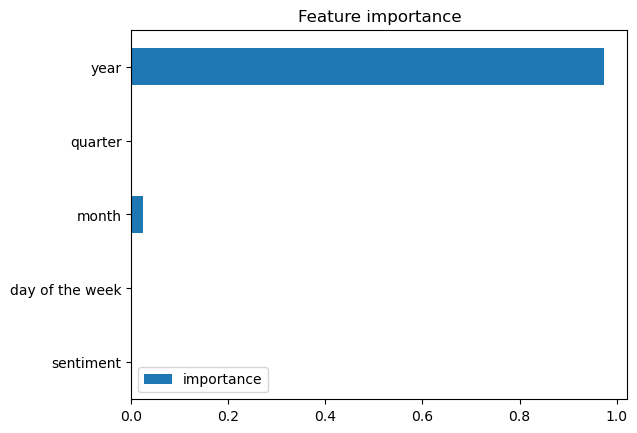

In [61]:
feature_importance.plot(kind="barh", title= "Feature importance")

In [62]:
y_pred = xgb_model.predict(X_test)
y_pred

array([-0.9313609 , -0.9313609 , -0.25533244, -0.9313609 , -0.9313609 ,
       -0.9313609 , -0.9313609 , -0.9313609 , -0.9313609 , -0.9313609 ,
       -0.9313609 , -0.9313609 , -0.25533244, -0.9313609 , -0.9313609 ,
       -0.25533244, -0.9313609 , -0.9313609 , -0.9313609 , -0.9313609 ,
       -0.9313609 , -0.9313609 , -0.5257168 , -0.9313609 , -0.9313609 ,
       -0.9313609 , -0.9313609 , -0.9313609 , -0.5257168 , -0.06343722,
       -0.06343722, -0.9313609 , -0.9313609 , -0.25533244, -0.9313609 ,
       -0.9313609 , -0.9313609 , -3.9037678 , -0.9313609 , -0.9313609 ,
       -0.9313609 , -0.9313609 , -0.9313609 , -0.9313609 , -0.9313609 ,
       -3.9037678 , -0.9313609 , -0.9313609 , -0.25533244, -0.9313609 ,
       -0.9313609 , -0.9313609 , -0.9313609 , -0.9313609 , -0.9313609 ,
       -0.9313609 , -0.9313609 , -0.9313609 , -3.9037678 , -1.7016649 ,
       -1.7016649 , -1.7016649 , -1.7016649 , -1.7016649 , -1.7016649 ,
       -1.7016649 , -1.7016649 , -1.7016649 , -1.7016649 , -1.70

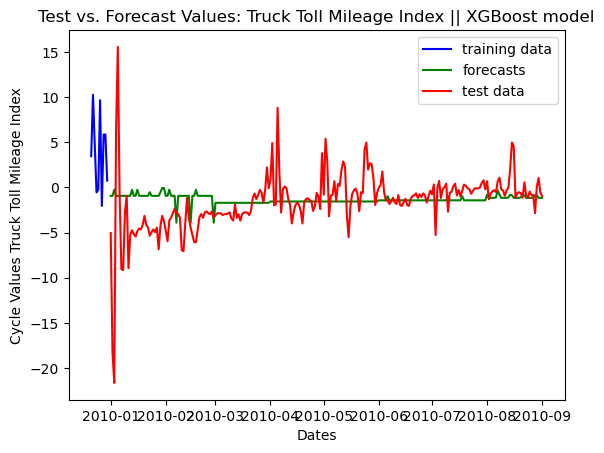

In [63]:
# Visualize the forecasts (blue=train, green=forecasts, red=test)
plt.plot(merged_df.index[720:730], merged_df["cycle_values"][720:730] , label="training data", c="blue")
plt.plot(merged_df.index[731:975], y_pred[:], label="forecasts", c="green")
plt.plot(merged_df.index[731:975], merged_df["cycle_values"][731:975], label="test data", c="red")
plt.xlabel('Dates')
plt.ylabel('Cycle Values Truck Toll Mileage Index')
plt.title('Test vs. Forecast Values: Truck Toll Mileage Index || XGBoost model')
plt.legend()
plt.show()

In [64]:
y_pred_eval=xgb_model.predict(merged_df[FEATURES][975:1000])
y_pred_eval

array([-1.1547824 , -1.0968819 , -0.86677265, -0.86677265, -1.1547824 ,
       -1.1547824 , -1.1547824 , -1.1547824 , -1.0968819 , -0.86677265,
       -0.22877797, -1.1547824 , -1.1547824 , -1.1547824 , -1.1547824 ,
       -1.055413  , -0.80317676, -0.86677265, -1.1547824 , -1.1547824 ,
       -1.1547824 , -1.1547824 , -1.0968819 , -0.86677265, -0.86677265],
      dtype=float32)

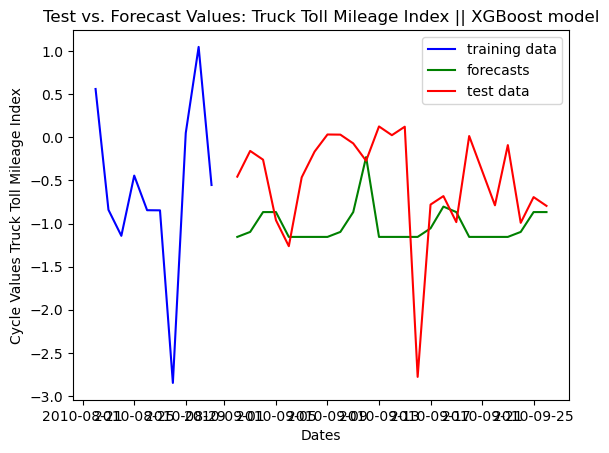

In [65]:
# Visualize the forecasts (blue=train, green=forecasts, red=test)
plt.plot(merged_df.index[964:974], merged_df["cycle_values"][964:974] , label="training data", c="blue")
plt.plot(merged_df.index[975:1000], y_pred_eval[:], label="forecasts", c="green")
plt.plot(merged_df.index[975:1000], merged_df["cycle_values"][975:1000], label="test data", c="red")
plt.xlabel('Dates')
plt.ylabel('Cycle Values Truck Toll Mileage Index')
plt.title('Test vs. Forecast Values: Truck Toll Mileage Index || XGBoost model')
plt.legend()
plt.show()

In [66]:
mse = mean_squared_error(merged_df["cycle_values"][975:1000], y_pred_eval[:])
print(f"The Mean Squared Error from the XGBoost model is equal to: {mse}")

The Mean Squared Error from the XGBoost model is equal to: 0.6887737410877


#### Time-Series Cross-Validation

In the last part of this section, I will split the forecasting time-horizon into eight 3 period splits and then analyze the performance of both the VAR and the ARMA model in all of these splits to see if the results found earlier hold more generally.

In [41]:
number_of_splits=8
tss = TimeSeriesSplit(n_splits=number_of_splits, test_size=3, gap=0)
tss

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=3)

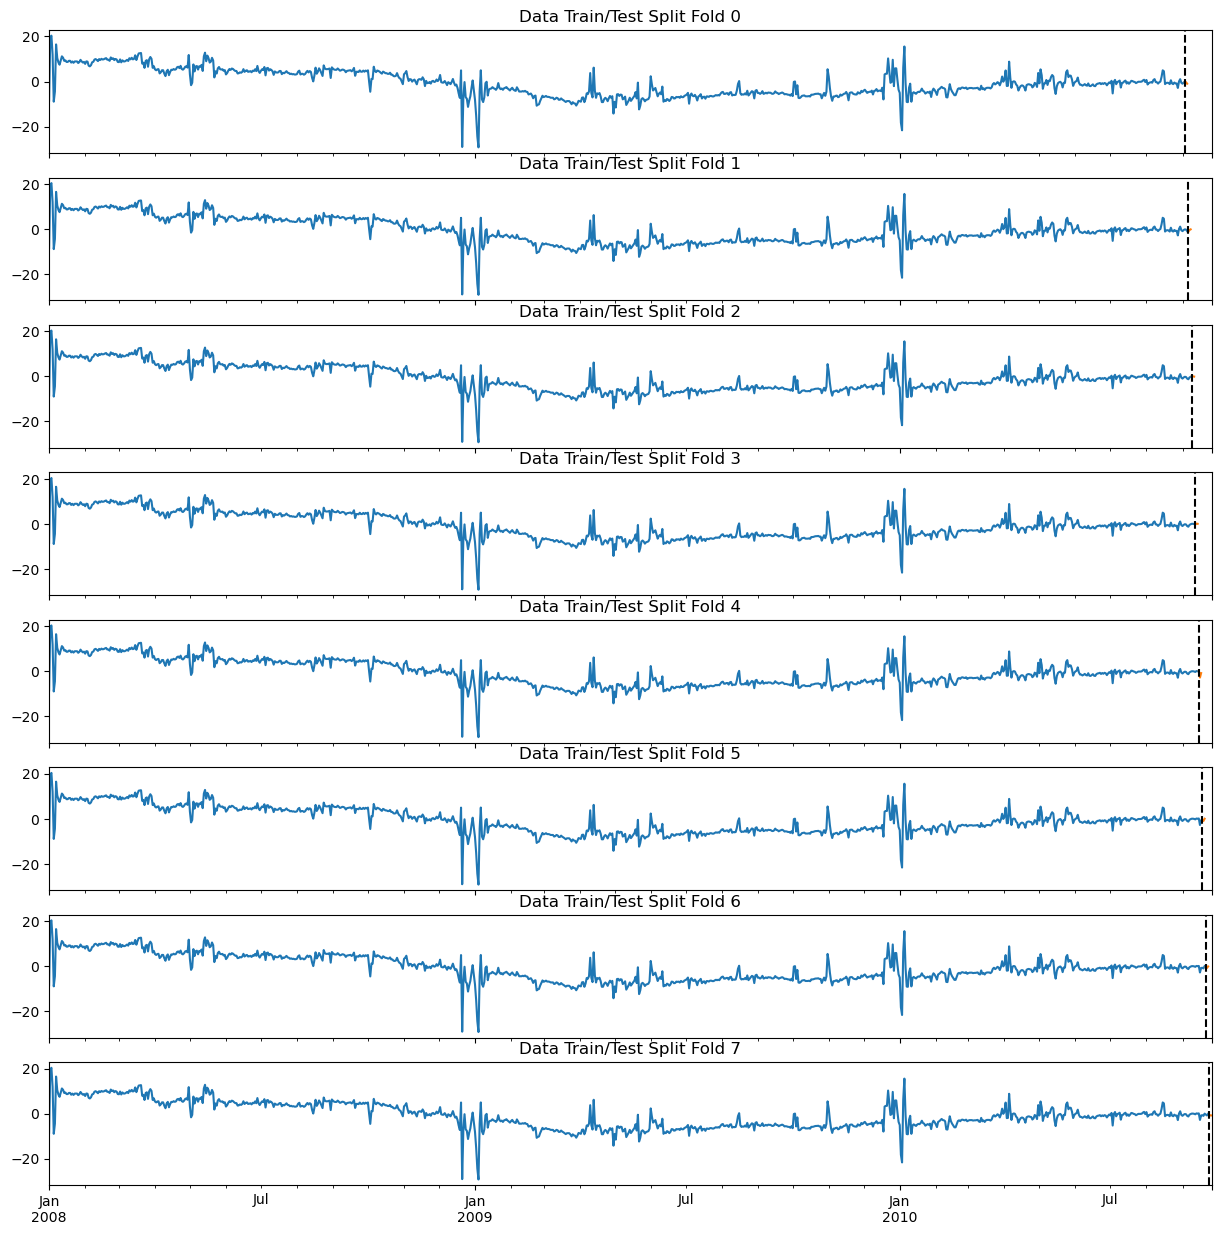

In [42]:
# Plotting all eight time-periods below one another
fig, axs = plt.subplots(number_of_splits, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(merged_df["cycle_values"]):
    train = merged_df.iloc[train_idx]
    test = merged_df.iloc[val_idx]
    train['cycle_values'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['cycle_values'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

At next, I will train the ARMA (3,1) model that was selected earlier on all eight possible training datasets and then make predictions three periods into the future and print out the mean squared error for all of these eight three period time-horizons.

In [43]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(merged_df["cycle_values"]):
    train = merged_df.iloc[train_idx] # define the training data
    test = merged_df.iloc[val_idx] # define the test data

    X_train = train["cycle_values"]

    y_test = test["cycle_values"]
    
    model = ARIMA(X_train,
                  order=(3,0,1),
                 enforce_stationarity=False,
                 freq="D",seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit() # fit the model on the training data
    y_pred = model_fit.predict(start=len(X_train)+1, end=len(X_train)+len(y_test)) # make predictions
    preds.append(y_pred) # store predictions
    score = mean_squared_error(y_test, y_pred) # score the predictions
    scores.append(score) # store scores
# Print out the scores for all the time-horizons
scores

C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda3\envs\dl_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

[0.12542116266747805,
 0.23122715377944073,
 0.33327287883477974,
 0.17155940984390602,
 2.3197874448768685,
 0.23387912573316472,
 0.12740820091133895,
 0.11559336651306025]

Now I do the same for the VAR model.

In [44]:
fold = 0
VAR_preds = []
VAR_scores = []
for train_idx, val_idx in tss.split(merged_df["cycle_values"]):
    train = merged_df.iloc[train_idx] # define the training data
    test = merged_df.iloc[val_idx] # define the test data

    COMPONENTS=["cycle_values","sentiment"]

    X_train = train[COMPONENTS]

    y_test = test["cycle_values"]
    
    model = VAR(X_train, freq="D")
    model_fit_VAR=model.fit(maxlags=14) # fit the model
    y_forecasts = model_fit_VAR.forecast(X_train.values, steps=len(y_test)) # make forecasts into the future
    columns = ['forecast_cycle_values', 'forecast_sentiment']
    VAR_forecast_df = pd.DataFrame(y_forecasts, columns=columns, index=y_test.index)
    VAR_preds.append(VAR_forecast_df["forecast_cycle_values"]) # store forecasts
    VAR_score = mean_squared_error(y_test, VAR_forecast_df["forecast_cycle_values"]) # score the forecasts
    VAR_scores.append(VAR_score) # store scores

# Print out the scores for the VAR model
VAR_scores

[0.3959612923575329,
 0.06961515991401701,
 0.894436058716634,
 0.2710344849335696,
 2.599259984692075,
 0.2064973136325787,
 0.10303205143504857,
 0.7455614657698004]

As we can see the VAR model does worse on most of the time-horizons (In my specific case, the ARMA model outperforms the VAR model in 5 out of 8 possible time-horizons), but better on some of the time-horizons potentially indicating that further training and tuning could lead to the VAR model outperforming the ARMA model in the very short-run. However, until now this is only speculation and would have to be examined in further work.

Lastly, I will plot the predictions of both models for all possible time-horizons.

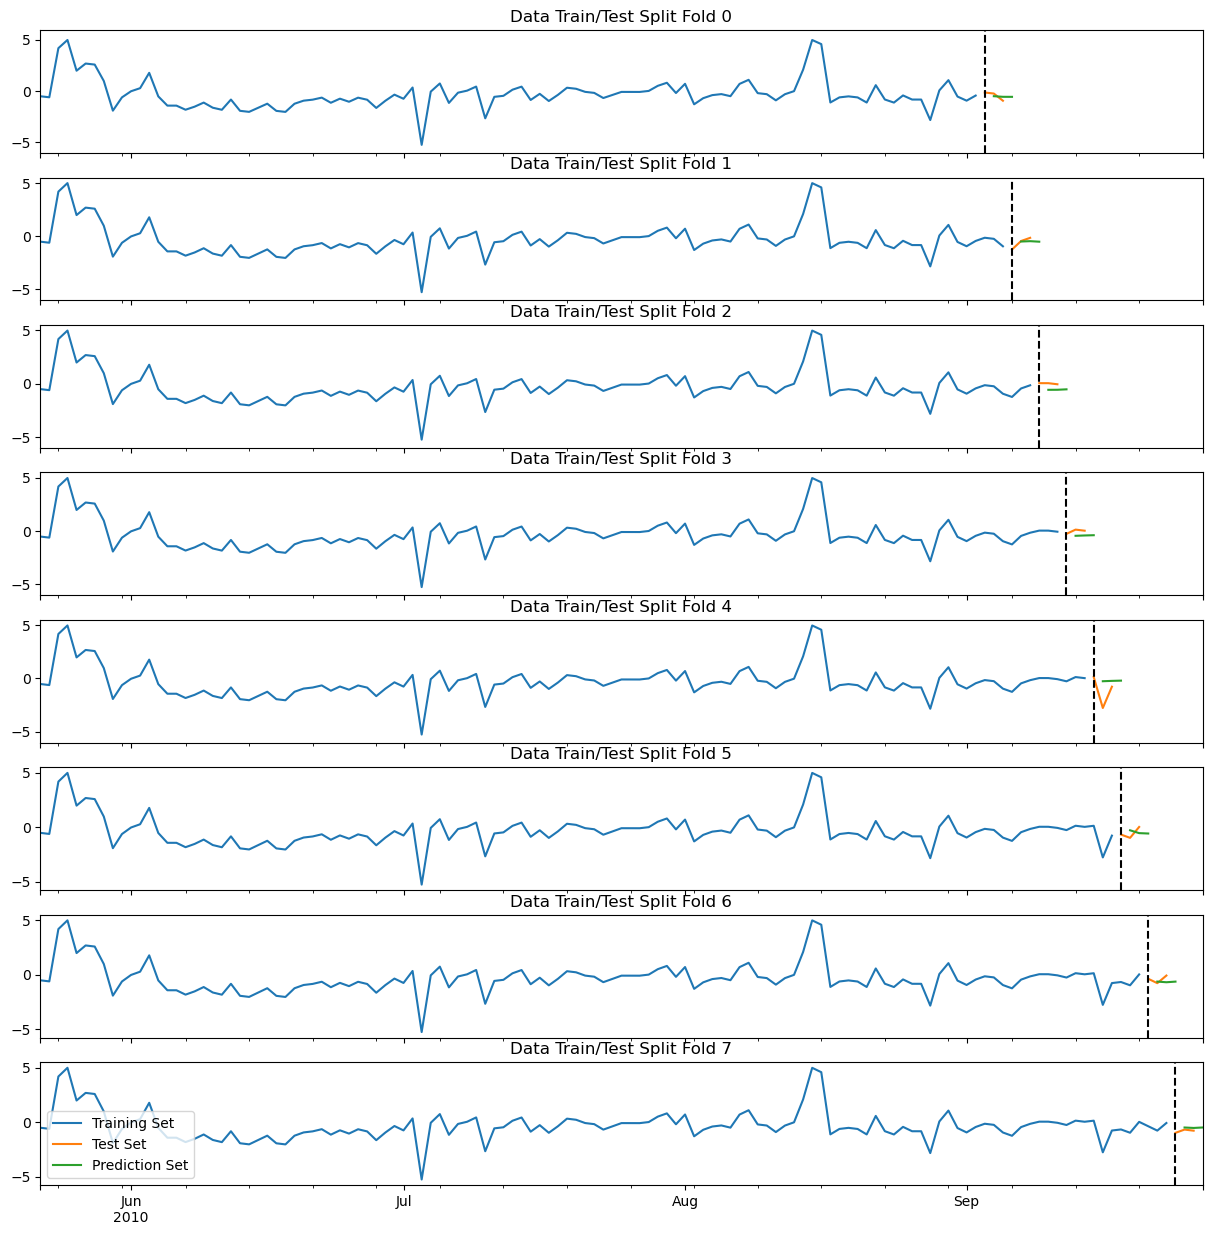

In [47]:
fig, axs = plt.subplots(number_of_splits, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(merged_df["cycle_values"]):
    train = merged_df.iloc[train_idx]
    test = merged_df.iloc[val_idx]
    train['cycle_values'][len(train)-125:].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['cycle_values'].plot(ax=axs[fold],
                         label='Test Set')
    preds[fold].plot(ax=axs[fold],
                     label="Prediction Set")
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.legend()
plt.show()

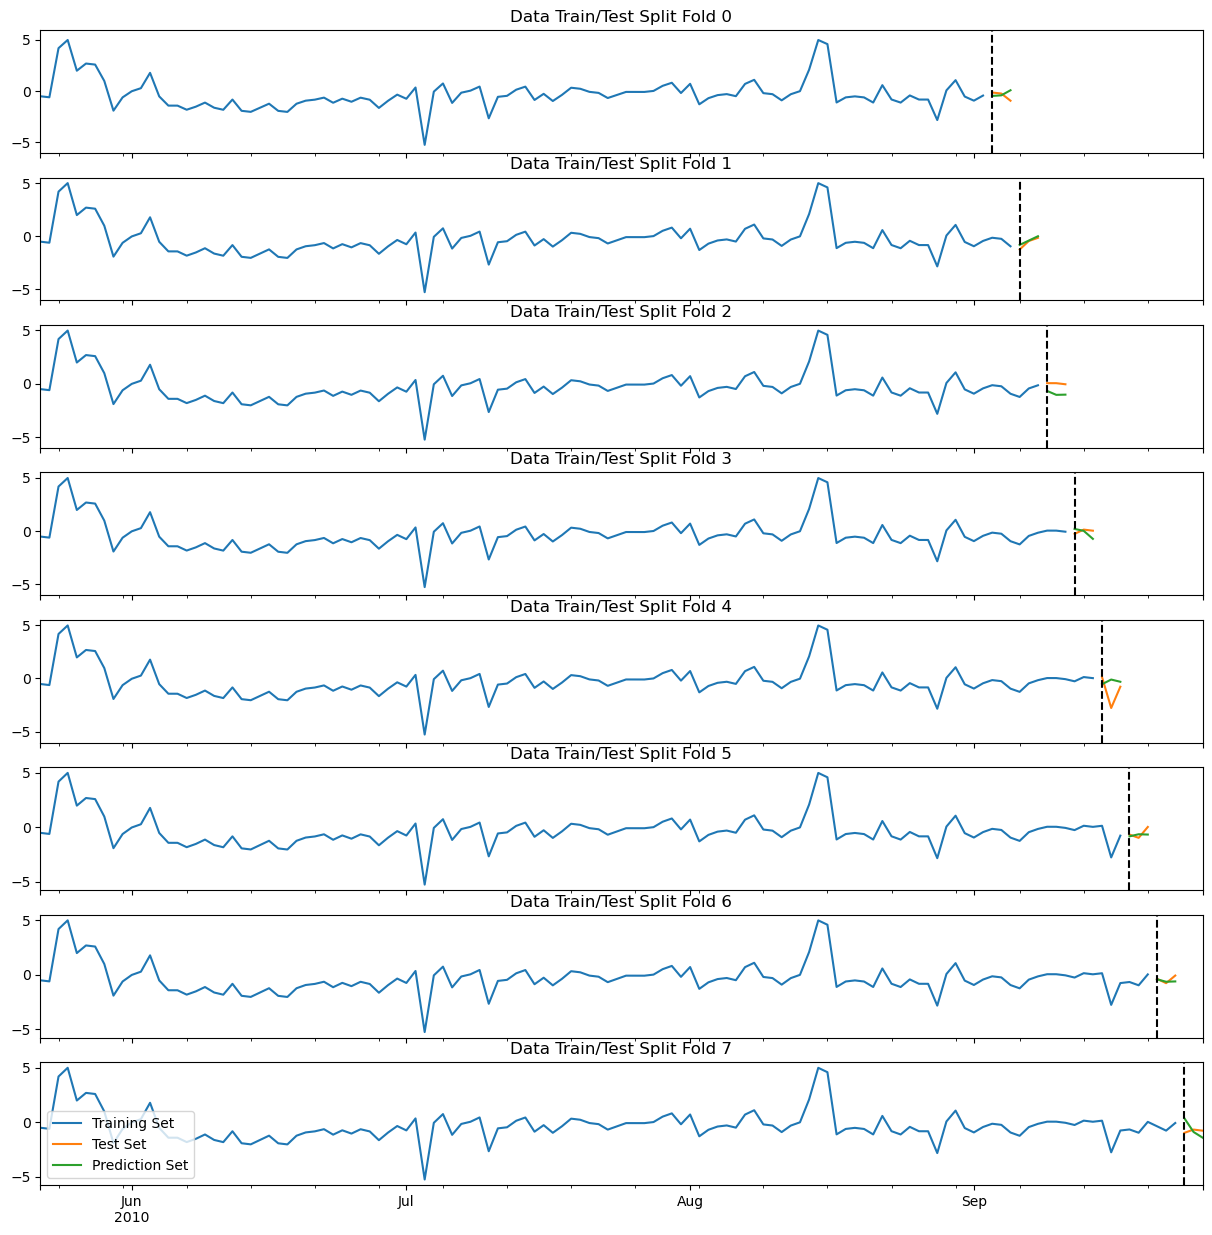

In [52]:
fig, axs = plt.subplots(number_of_splits, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(merged_df["cycle_values"]):
    train = merged_df.iloc[train_idx]
    test = merged_df.iloc[val_idx]
    train['cycle_values'][len(train)-125:].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['cycle_values'].plot(ax=axs[fold],
                         label='Test Set')
    VAR_preds[fold].plot(ax=axs[fold],
                     label="Prediction Set")
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.legend()
plt.show()